### remember to change model saving path!!!

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import random
import torch.nn as nn
from dataset import Thyroid_Dataset
from model import Eff_Unet
from HarDMSEG import HarDMSEG
from loss_metric import DiceLoss, IOU_score, StructureLoss, TverskyLoss
from LightMed.model.LightMed import LightMed
from PMFSNet.lib.models.PMFSNet import PMFSNet
from PMFSNet.lib.models.PMFSNet_FFT import PMFSNet_FFT
from hybrid_model_v3 import HybridSegModel

/home/twszbak764/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/twszbak764/.local/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/twszbak764/.local/lib/python3.12/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
import wandb
wandb.login()

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: s960068sss (s960068sss-ucl) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms.functional as tx
import random
import cv2
from PIL import ImageEnhance
from skimage.exposure import match_histograms
import torchvision.transforms as T
import torchvision.transforms.functional as F
class Ge_Benq_Dataset(Dataset):
    def __init__(self, csv_file, transform, image_size, training = True):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.image_size = image_size
        self.training = training
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_name = self.df["image_name"][idx]
        mask_name = self.df["mask_name"][idx]
        dataset = self.df["dataset"][idx]
        mask_type = self.df["mask_type"][idx]
        inference = self.df["inference"][idx]
        
        if dataset == "ge":
            from_dataset = 1
        elif dataset == "benq":
            from_dataset = 2

        if mask_type == "nodule":
            mask_type = 1
        elif mask_type == "gland":
            mask_type = 2

            
        if dataset == "benq":
            from_folder = "../gland_data"
        elif dataset == "ge":
            if mask_type == 1:
                if self.training:
                    from_folder = "../ge_data/nodule/train"
                else:
                    from_folder = "../ge_data/nodule/test"
            else:
                from_folder = "../ge_data/gland"
                
        if inference == False:
            image_path = f"{from_folder}/images/{image_name}"
            mask_path = f"{from_folder}/masks/{mask_name}"
        else:
            image_path = f"../ge_data/from_videos/images/{image_name}"
            if mask_type == 1:
                mask_path = f"../ge_data/from_videos/inference_mask_from_scratch_v1/nodule/{mask_name}"
            else:
                mask_path = f"../ge_data/from_videos/inference_mask_from_scratch_v1/gland/{mask_name}"

        image = Image.open(image_path).convert("L")
        mask = Image.open(mask_path).convert("L")
        
        image_tensor, mask_tensor = self.transform(image, mask, self.image_size)
        mask_tensor = (mask_tensor > 0.5).float()
        if torch.sum(mask_tensor) == 0:
            # print("nothing")
            return [None]
        return image_tensor, mask_tensor, from_dataset, mask_type, inference

In [6]:
image_size = 128
batch_size = 256
def train_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    p = 0.7
    
    # if(random.random() < p):
    #     jitter = T.ColorJitter(brightness = 0.5, contrast = 0.25)
    #     image = jitter(image)
    # if(random.random() < p):
    #     transform = T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
    #     image = transform(image)  # image must be a PIL image
    if(random.random() < p):
        # angle = random.uniform(-10, 10)  # 旋轉角度從 ±10 度
        angle = 0.0
        max_dx = 0.05  # 水平平移比例
        max_dy = 0.3  # 垂直平移比例
        translate_x = random.uniform(-max_dx, max_dx) * image.size[0]
        translate_y = random.uniform(-max_dy, max_dy) * image.size[1]
        translate = (int(translate_x), int(translate_y))
        scale = random.uniform(0.9, 1.6)  # 尺度縮放 ±5%
        # scale = 1.0
        # shear = [random.uniform(-5, 5), random.uniform(-5, 5)]  # 小幅剪切
        shear=[0.0, 0.0]
        image = F.affine(image, angle=angle, translate=translate, scale=scale, shear=shear)
        mask = F.affine(mask, angle=angle, translate=translate, scale=scale, shear=shear)

        
    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor
def test_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor
def custom_collate_fn(batch):
    # print(batch)
    filtered_batch = [item for item in batch if item[0] is not None]
    if len(filtered_batch) == 0:
        return [None, None]
    return torch.utils.data.dataloader.default_collate(filtered_batch)
train_dataset = Ge_Benq_Dataset("../ge_benq_data/ge_benq_train_v3.csv", transform = train_augmentation, image_size = image_size)
train_dataloader = DataLoader(train_dataset, batch_size = 256, shuffle = True, collate_fn=custom_collate_fn)

test_dataset = Ge_Benq_Dataset("../ge_benq_data/ge_benq_test_v3.csv", transform = test_augmentation, image_size = image_size, training = False)
test_dataloader = DataLoader(test_dataset, batch_size = 128, shuffle = False, collate_fn=custom_collate_fn)

image, mask, from_dataset, mask_type, inference = next(iter(train_dataloader))

In [7]:
print(len(train_dataset), len(test_dataset))

1077 229


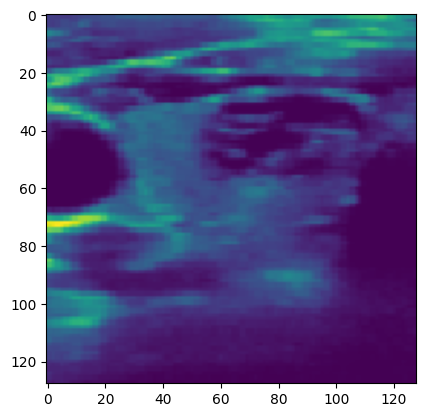

In [8]:
plt.imshow(image[22][0])

In [9]:
def train(dataloader, model, optimizer, loss_fn, device):
    total_loss = 0
    total_IOU = 0
    total_DICE = 0

    total_ge_nodule_IOU = 0
    total_ge_gland_IOU = 0
    total_benq_gland_IOU = 0
    
    total_ge_nodule_DICE = 0
    total_ge_gland_DICE = 0
    total_benq_gland_DICE = 0
    
    model.train()
    model.to(device)
    
    count = 0
    for image, mask, from_dataset, mask_type, infernce in tqdm(dataloader):
        if image == None:
            continue
        image, mask = image.to(device), mask.to(device)
        
        outputs = model(image)
        
        nodule_output = outputs[:, 0:1, :, :]
        gland_output = outputs[:, 1:2, :, :]

        # get output
        ge_nodule_output = nodule_output[(from_dataset == 1) & (mask_type == 1)]
        ge_gland_output = gland_output[(from_dataset == 1) & (mask_type == 2)]
        benq_gland_output = gland_output[(from_dataset == 2) & (mask_type == 2)]

        # get len
        ge_nodule_len = ge_nodule_output.shape[0]
        ge_gland_len = ge_gland_output.shape[0]
        benq_gland_len = benq_gland_output.shape[0]

        if ge_nodule_len == 0 or ge_gland_len == 0 or benq_gland_len == 0:
            continue

        nodule_ratio = ge_nodule_len / (ge_nodule_len + ge_gland_len + benq_gland_len)
        gland_ratio = (ge_gland_len + benq_gland_len) / (ge_nodule_len + ge_gland_len + benq_gland_len)
        
        ge_gland_ratio = ge_gland_len / (ge_gland_len + benq_gland_len)
        benq_gland_ratio = benq_gland_len / (ge_gland_len + benq_gland_len)
        
        # get mask
        ge_nodule_mask = mask[(from_dataset == 1) & (mask_type == 1)]
        ge_gland_mask = mask[(from_dataset == 1) & (mask_type == 2)]
        benq_gland_mask = mask[(from_dataset == 2) & (mask_type == 2)]
        
        #get loss
        ge_nodule_loss = loss_fn(ge_nodule_output, ge_nodule_mask)
        ge_gland_loss = loss_fn(ge_gland_output, ge_gland_mask)
        benq_gland_loss = loss_fn(benq_gland_output, benq_gland_mask)

        nodule_loss = ge_nodule_loss
        gland_loss = (ge_gland_loss * ge_gland_ratio + benq_gland_loss * benq_gland_ratio)
        loss = (nodule_loss * nodule_ratio * 1.3 + gland_loss * gland_ratio * 0.7)
        
        # get IOU
        ge_nodule_IOU = IOU_score(ge_nodule_output, ge_nodule_mask)
        ge_gland_IOU = IOU_score(ge_gland_output, ge_gland_mask)
        benq_gland_IOU = IOU_score(benq_gland_output, benq_gland_mask)

        nodule_IOU = ge_nodule_IOU
        gland_IOU = (ge_gland_IOU * ge_gland_ratio + benq_gland_IOU * benq_gland_ratio)
        IOU = (nodule_IOU * nodule_ratio + gland_IOU * gland_ratio)

        # get DICE
        dice_loss = DiceLoss()
        
        ge_nodule_DICE = 1 - dice_loss(ge_nodule_output, ge_nodule_mask)
        ge_gland_DICE = 1 - dice_loss(ge_gland_output, ge_gland_mask)
        benq_gland_DICE = 1 - dice_loss(benq_gland_output, benq_gland_mask)

        nodule_DICE = ge_nodule_DICE
        gland_DICE = (ge_gland_DICE * ge_gland_ratio + benq_gland_DICE * benq_gland_ratio)
        DICE = (nodule_DICE * nodule_ratio + gland_DICE * gland_ratio)

        
        # Backward and optimize
        optimizer.zero_grad()   # clear previous gradients
        loss.backward()         # compute gradients
        optimizer.step()        # update weights

        total_loss += loss.item()
        total_IOU += IOU.item()
        total_DICE += DICE.item()

        total_ge_nodule_IOU += ge_nodule_IOU
        total_ge_gland_IOU += ge_gland_IOU
        total_benq_gland_IOU += benq_gland_IOU

        total_ge_nodule_DICE += ge_nodule_DICE
        total_ge_gland_DICE += ge_gland_DICE
        total_benq_gland_DICE += benq_gland_DICE
        count+=1

    return total_loss/count, total_IOU/count, total_DICE/count, total_ge_nodule_IOU/count, total_ge_gland_IOU/count, total_benq_gland_IOU/count, total_ge_nodule_DICE/count, total_ge_gland_DICE/count, total_benq_gland_DICE/count


# 
# Only calculate nodule loss, IOU, DICE, because there is no gland data in the testing set
def val(dataloader, model, loss_fn, device):
    total_loss = 0
    total_IOU = 0
    total_DICE = 0

    total_ge_nodule_IOU = 0
    total_ge_gland_IOU = 0
    total_benq_gland_IOU = 0
    
    total_ge_nodule_DICE = 0
    total_ge_gland_DICE = 0
    total_benq_gland_DICE = 0
    
    model.train()
    model.to(device)
    count = 0
    for image, mask, from_dataset, mask_type, infernce in tqdm(dataloader):
        if image == None:
            continue
        image, mask = image.to(device), mask.to(device)
        
        outputs = model(image)
        
        nodule_output = outputs[:, 0:1, :, :]
        gland_output = outputs[:, 1:2, :, :]

        # get output
        ge_nodule_output = nodule_output[(from_dataset == 1) & (mask_type == 1)]
        ge_gland_output = gland_output[(from_dataset == 1) & (mask_type == 2)]
        benq_gland_output = gland_output[(from_dataset == 2) & (mask_type == 2)]

        # get len
        ge_nodule_len = ge_nodule_output.shape[0]
        ge_gland_len = ge_gland_output.shape[0]
        benq_gland_len = benq_gland_output.shape[0]

        if ge_nodule_len == 0 or ge_gland_len == 0 or benq_gland_len == 0:
            continue
        nodule_ratio = ge_nodule_len / (ge_nodule_len + ge_gland_len + benq_gland_len)
        gland_ratio = (ge_gland_len + benq_gland_len) / (ge_nodule_len + ge_gland_len + benq_gland_len)
        
        ge_gland_ratio = ge_gland_len / (ge_gland_len + benq_gland_len)
        benq_gland_ratio = benq_gland_len / (ge_gland_len + benq_gland_len)
        
        # get mask
        ge_nodule_mask = mask[(from_dataset == 1) & (mask_type == 1)]
        ge_gland_mask = mask[(from_dataset == 1) & (mask_type == 2)]
        benq_gland_mask = mask[(from_dataset == 2) & (mask_type == 2)]
        
        #get loss
        ge_nodule_loss = loss_fn(ge_nodule_output, ge_nodule_mask)
        ge_gland_loss = loss_fn(ge_gland_output, ge_gland_mask)
        benq_gland_loss = loss_fn(benq_gland_output, benq_gland_mask)

        nodule_loss = ge_nodule_loss
        gland_loss = (ge_gland_loss * ge_gland_ratio + benq_gland_loss * benq_gland_ratio)
        loss = (nodule_loss * nodule_ratio + gland_loss * gland_ratio)
        
        # get IOU
        ge_nodule_IOU = IOU_score(ge_nodule_output, ge_nodule_mask)
        ge_gland_IOU = IOU_score(ge_gland_output, ge_gland_mask)
        benq_gland_IOU = IOU_score(benq_gland_output, benq_gland_mask)

        nodule_IOU = ge_nodule_IOU
        gland_IOU = (ge_gland_IOU * ge_gland_ratio + benq_gland_IOU * benq_gland_ratio)
        IOU = (nodule_IOU * nodule_ratio + gland_IOU * gland_ratio)

        # get DICE
        dice_loss = DiceLoss()
        
        ge_nodule_DICE = 1 - dice_loss(ge_nodule_output, ge_nodule_mask)
        ge_gland_DICE = 1 - dice_loss(ge_gland_output, ge_gland_mask)
        benq_gland_DICE = 1 - dice_loss(benq_gland_output, benq_gland_mask)

        nodule_DICE = ge_nodule_DICE
        gland_DICE = (ge_gland_DICE * ge_gland_ratio + benq_gland_DICE * benq_gland_ratio)
        DICE = (nodule_DICE * nodule_ratio + gland_DICE * gland_ratio)

        total_loss += loss.item()
        total_IOU += IOU.item()
        total_DICE += DICE.item()

        total_ge_nodule_IOU += ge_nodule_IOU
        total_ge_gland_IOU += ge_gland_IOU
        total_benq_gland_IOU += benq_gland_IOU

        total_ge_nodule_DICE += ge_nodule_DICE
        total_ge_gland_DICE += ge_gland_DICE
        total_benq_gland_DICE += benq_gland_DICE
        count+=1

    return total_loss/count, total_IOU/count, total_DICE/count, total_ge_nodule_IOU/count, total_ge_gland_IOU/count, total_benq_gland_IOU/count, total_ge_nodule_DICE/count, total_ge_gland_DICE/count, total_benq_gland_DICE/count

    

In [10]:

# inference_name = "models/Phase 1/Hybrid_crop_DDTI_standardization_aug_affine(0.5)_for_gland"

model = HybridSegModel(in_channels = 1, out_channels = 2, output_size = image_size, layers_num = 3)
# checkpoint = torch.load(f"{inference_name}/best_checkpoint.pth")
# model.load_state_dict(checkpoint['model_state_dict'])


In [11]:
# freeze encoder
# for param in model.backbone.parameters():
#     param.requires_grad = False

In [12]:

epochs = 500
lr = 0.01
loss_fn = StructureLoss()
# loss_fn = TverskyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
# optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [14]:

project = "thyroid_ge_benq_from_scratch"
# name = "hybrid_model_ge(nodule_gland_inference)_v3_benq(crop_gland)_baseline(1)_freeze_encoder_aug_space_adjust_loss(1.3_0.7)"
name = "from_scratch_ge(nodule_gland_inference)_benq(crop_gland)_data_v1"

wandb.init(
    project = project,  # Project name in W&B
    name = name,       # (optional) specific run name
    config={                     # (optional) hyperparameters
        "image_size": image_size,
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        # "weight_decay":1e-4
    }
)

In [15]:
print(f"image size : {image_size}, lr : {lr}, epochs : {epochs}, batch size : {batch_size}")

image size : 128, lr : 0.01, epochs : 500, batch size : 256


In [16]:
max_IOU = -1
for epoch in range(epochs):
    print(f"epoch : {epoch}")
    total_loss_train, total_IOU_train, total_DICE_train, ge_nodule_IOU_train, ge_gland_IOU_train, benq_gland_IOU_train, ge_nodule_DICE_train, ge_gland_DICE_train, benq_gland_DICE_train = train(train_dataloader, model, optimizer, loss_fn, "cuda")
    print(f"train loss : {total_loss_train}, train IOU : {total_IOU_train}, train DICE : {total_DICE_train}")
    total_loss_val, total_IOU_val, total_DICE_val, ge_nodule_IOU_val, ge_gland_IOU_val, benq_gland_IOU_val, ge_nodule_DICE_val, ge_gland_DICE_val, benq_gland_DICE_val = val(test_dataloader, model, loss_fn, "cuda")
    print(f"val loss : {total_loss_val}, val IOU : {total_IOU_val}, val DICE : {total_DICE_val}")
    
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]



    if max_IOU < total_IOU_val:
        max_IOU = total_IOU_val
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            "IOU" : total_IOU_val,
            "DICE" : total_DICE_val,
            "loss" : total_loss_val
        }
        folder = f"models/finetune/ge_benq/{name}/"
        if not os.path.exists(folder):
            os.mkdir(folder)
        torch.save(checkpoint, f"models/finetune/ge_benq/{name}/best_checkpoint.pth")

    
    wandb.log({
        "epoch": epoch,
        "Learning Rate":current_lr,
        
        "train_loss": total_loss_train,
        "train_IOU": total_IOU_train,
        "train_DICE": total_DICE_train,
        "train_ge_nodule_IOU" : ge_nodule_IOU_train,
        "train_ge_nodule_DICE" : ge_nodule_DICE_train,
        "train_ge_gland_IOU" : ge_gland_IOU_train,
        "train_ge_gland_DICE" : ge_gland_DICE_train,
        "train_benq_gland_IOU" : benq_gland_IOU_train,
        "train_benq_gland_DICE" : benq_gland_DICE_train,
        
        "val_loss": total_loss_val,
        "val_IOU": total_IOU_val,
        "val_DICE": total_DICE_val,
        "val_ge_nodule_IOU" : ge_nodule_IOU_val,
        "val_ge_nodule_DICE" : ge_nodule_DICE_val,
        "val_ge_gland_IOU" : ge_gland_IOU_val,
        "val_ge_gland_DICE" : ge_gland_DICE_val,
        "val_benq_gland_IOU" : benq_gland_IOU_val,
        "val_benq_gland_DICE" : benq_gland_DICE_val,
        
    })




checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    "IOU" : total_IOU_val,
    "DICE" : total_DICE_val,
    "loss" : total_loss_val
}
torch.save(checkpoint, f"models/finetune/ge_benq/{name}/last_checkpoint.pth")
wandb.finish()

epoch : 0


/home/twszbak764/miniconda3/envs/thyroid/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 5/5 [00:27<00:00,  5.55s/it]


train loss : 1.351252007484436, train IOU : 0.10084239915013313, train DICE : 0.21146484911441804


100%|██████████| 2/2 [00:03<00:00,  1.84s/it]


val loss : 1.106555163860321, val IOU : 0.13610996305942535, val DICE : 0.24025162309408188
epoch : 1


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


train loss : 1.1870859622955323, train IOU : 0.12637135088443757, train DICE : 0.26754129528999326


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 1.028609037399292, val IOU : 0.22790170460939407, val DICE : 0.31424568593502045
epoch : 2


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


train loss : 1.049509596824646, train IOU : 0.2564807742834091, train DICE : 0.3569944500923157


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.9727569222450256, val IOU : 0.30885349214076996, val DICE : 0.379794642329216
epoch : 3


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


train loss : 0.9776739954948426, train IOU : 0.3481451034545898, train DICE : 0.44412511587142944


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.8868080973625183, val IOU : 0.36453917622566223, val DICE : 0.44768601655960083
epoch : 4


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.9297549247741699, train IOU : 0.37709195613861085, train DICE : 0.49332348108291624


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.8488551676273346, val IOU : 0.3958785831928253, val DICE : 0.48402370512485504
epoch : 5


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


train loss : 0.8823388457298279, train IOU : 0.40188785195350646, train DICE : 0.5215698122978211


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.7748371064662933, val IOU : 0.46521924436092377, val DICE : 0.5467692017555237
epoch : 6


100%|██████████| 5/5 [00:13<00:00,  2.67s/it]


train loss : 0.861531937122345, train IOU : 0.4138098776340485, train DICE : 0.5281656503677368


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.821619987487793, val IOU : 0.422911673784256, val DICE : 0.5165339708328247
epoch : 7


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


train loss : 0.817062509059906, train IOU : 0.43455583453178404, train DICE : 0.5516642570495606


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.7603926956653595, val IOU : 0.4719997048377991, val DICE : 0.5599021315574646
epoch : 8


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


train loss : 0.8020577907562256, train IOU : 0.4514491677284241, train DICE : 0.5721577405929565


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.7816201448440552, val IOU : 0.44985635578632355, val DICE : 0.5556546747684479
epoch : 9


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


train loss : 0.787972342967987, train IOU : 0.46700540781021116, train DICE : 0.5865903735160828


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.7674101293087006, val IOU : 0.4654921442270279, val DICE : 0.5660435557365417
epoch : 10


100%|██████████| 5/5 [00:13<00:00,  2.67s/it]


train loss : 0.7729551553726196, train IOU : 0.4714213371276855, train DICE : 0.5930784344673157


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.7230981290340424, val IOU : 0.4991600811481476, val DICE : 0.6061388254165649
epoch : 11


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


train loss : 0.7718855381011963, train IOU : 0.48113876581192017, train DICE : 0.6020922422409057


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.6958055198192596, val IOU : 0.5150950253009796, val DICE : 0.6253401339054108
epoch : 12


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.7454146385192871, train IOU : 0.49477158188819886, train DICE : 0.6132740139961242


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.761900931596756, val IOU : 0.4675298035144806, val DICE : 0.5741050541400909
epoch : 13


100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


train loss : 0.7231878161430358, train IOU : 0.5038115739822387, train DICE : 0.6263689517974853


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.6775229275226593, val IOU : 0.5352310538291931, val DICE : 0.6407560110092163
epoch : 14


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


train loss : 0.7081300616264343, train IOU : 0.5199972629547119, train DICE : 0.6289781332015991


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.7004653811454773, val IOU : 0.5264741778373718, val DICE : 0.6079265773296356
epoch : 15


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


train loss : 0.7123047947883606, train IOU : 0.5184739470481873, train DICE : 0.626768696308136


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.6943737864494324, val IOU : 0.5092666149139404, val DICE : 0.6141213774681091
epoch : 16


100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


train loss : 0.7023576140403748, train IOU : 0.5211418986320495, train DICE : 0.6428828597068786


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.7125785052776337, val IOU : 0.5116496682167053, val DICE : 0.6266198754310608
epoch : 17


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.6933932542800904, train IOU : 0.5254356384277343, train DICE : 0.6480815649032593


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.6576547920703888, val IOU : 0.5459174811840057, val DICE : 0.6419845223426819
epoch : 18


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


train loss : 0.6677628874778747, train IOU : 0.5428909182548523, train DICE : 0.6611299157142639


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.7063029110431671, val IOU : 0.5079592913389206, val DICE : 0.6120919287204742
epoch : 19


100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


train loss : 0.6738037467002869, train IOU : 0.539936101436615, train DICE : 0.6668701648712159


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.6383711993694305, val IOU : 0.5585426986217499, val DICE : 0.6619390547275543
epoch : 20


100%|██████████| 5/5 [00:14<00:00,  2.90s/it]


train loss : 0.6454005360603332, train IOU : 0.5613531589508056, train DICE : 0.6688510775566101


100%|██████████| 2/2 [00:02<00:00,  1.35s/it]


val loss : 0.6325532793998718, val IOU : 0.5665959715843201, val DICE : 0.6717647612094879
epoch : 21


100%|██████████| 5/5 [00:14<00:00,  2.81s/it]


train loss : 0.6505235075950623, train IOU : 0.5663549304008484, train DICE : 0.6755599856376648


100%|██████████| 2/2 [00:02<00:00,  1.38s/it]


val loss : 0.6264374256134033, val IOU : 0.5658308863639832, val DICE : 0.6732994019985199
epoch : 22


100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


train loss : 0.6211527466773987, train IOU : 0.5753469824790954, train DICE : 0.6909047842025757


100%|██████████| 2/2 [00:02<00:00,  1.35s/it]


val loss : 0.6861126720905304, val IOU : 0.5306485295295715, val DICE : 0.6311252415180206
epoch : 23


100%|██████████| 5/5 [00:13<00:00,  2.79s/it]


train loss : 0.664938771724701, train IOU : 0.5517883896827698, train DICE : 0.6699742436408996


100%|██████████| 2/2 [00:02<00:00,  1.38s/it]


val loss : 0.6429431438446045, val IOU : 0.5471908152103424, val DICE : 0.6611899435520172
epoch : 24


100%|██████████| 5/5 [00:13<00:00,  2.80s/it]


train loss : 0.6222051501274108, train IOU : 0.5728955030441284, train DICE : 0.6821727275848388


100%|██████████| 2/2 [00:02<00:00,  1.36s/it]


val loss : 0.712843656539917, val IOU : 0.509667158126831, val DICE : 0.6182987689971924
epoch : 25


100%|██████████| 5/5 [00:13<00:00,  2.79s/it]


train loss : 0.6387709617614746, train IOU : 0.5696716070175171, train DICE : 0.691584050655365


100%|██████████| 2/2 [00:02<00:00,  1.36s/it]


val loss : 0.6041279137134552, val IOU : 0.5754526555538177, val DICE : 0.6854606866836548
epoch : 26


100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


train loss : 0.608230721950531, train IOU : 0.5821839094161987, train DICE : 0.6948306083679199


100%|██████████| 2/2 [00:02<00:00,  1.43s/it]


val loss : 0.561620682477951, val IOU : 0.6137385368347168, val DICE : 0.7130419015884399
epoch : 27


100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


train loss : 0.5994381427764892, train IOU : 0.5889356970787049, train DICE : 0.7024167656898499


100%|██████████| 2/2 [00:02<00:00,  1.41s/it]


val loss : 0.6149057149887085, val IOU : 0.5783737301826477, val DICE : 0.6898952126502991
epoch : 28


100%|██████████| 5/5 [00:14<00:00,  2.93s/it]


train loss : 0.5728898048400879, train IOU : 0.6170194268226623, train DICE : 0.7209526300430298


100%|██████████| 2/2 [00:02<00:00,  1.39s/it]


val loss : 0.5687665641307831, val IOU : 0.6089201867580414, val DICE : 0.7071501910686493
epoch : 29


100%|██████████| 5/5 [00:14<00:00,  2.90s/it]


train loss : 0.5811248660087586, train IOU : 0.6050303459167481, train DICE : 0.7096402645111084


100%|██████████| 2/2 [00:02<00:00,  1.36s/it]


val loss : 0.6024762392044067, val IOU : 0.5890284776687622, val DICE : 0.688121885061264
epoch : 30


100%|██████████| 5/5 [00:15<00:00,  3.01s/it]


train loss : 0.571733558177948, train IOU : 0.6120767712593078, train DICE : 0.7169416546821594


100%|██████████| 2/2 [00:02<00:00,  1.36s/it]


val loss : 0.5741733908653259, val IOU : 0.6119021773338318, val DICE : 0.7148748934268951
epoch : 31


100%|██████████| 5/5 [00:14<00:00,  2.92s/it]


train loss : 0.5378732204437255, train IOU : 0.6322303295135498, train DICE : 0.738595974445343


100%|██████████| 2/2 [00:02<00:00,  1.33s/it]


val loss : 0.5742267072200775, val IOU : 0.6074097156524658, val DICE : 0.7166816890239716
epoch : 32


100%|██████████| 5/5 [00:14<00:00,  2.92s/it]


train loss : 0.5349303960800171, train IOU : 0.6361815214157105, train DICE : 0.7369676470756531


100%|██████████| 2/2 [00:02<00:00,  1.34s/it]


val loss : 0.5266596078872681, val IOU : 0.6339377164840698, val DICE : 0.7375794053077698
epoch : 33


100%|██████████| 5/5 [00:14<00:00,  2.86s/it]


train loss : 0.5378654599189758, train IOU : 0.6355113744735718, train DICE : 0.743081557750702


100%|██████████| 2/2 [00:02<00:00,  1.35s/it]


val loss : 0.572963535785675, val IOU : 0.6118617951869965, val DICE : 0.7224223613739014
epoch : 34


100%|██████████| 5/5 [00:14<00:00,  2.95s/it]


train loss : 0.5215577006340026, train IOU : 0.6436249494552613, train DICE : 0.7501868367195129


100%|██████████| 2/2 [00:02<00:00,  1.34s/it]


val loss : 0.5349291563034058, val IOU : 0.6313485503196716, val DICE : 0.730500340461731
epoch : 35


100%|██████████| 5/5 [00:14<00:00,  2.86s/it]


train loss : 0.489989823102951, train IOU : 0.6652835369110107, train DICE : 0.7610582828521728


100%|██████████| 2/2 [00:02<00:00,  1.36s/it]


val loss : 0.5626406967639923, val IOU : 0.6189627051353455, val DICE : 0.7268129289150238
epoch : 36


100%|██████████| 5/5 [00:14<00:00,  2.81s/it]


train loss : 0.5280315577983856, train IOU : 0.6454845905303955, train DICE : 0.7535588145256042


100%|██████████| 2/2 [00:02<00:00,  1.36s/it]


val loss : 0.5735140442848206, val IOU : 0.6017149090766907, val DICE : 0.712011992931366
epoch : 37


100%|██████████| 5/5 [00:14<00:00,  2.88s/it]


train loss : 0.5099603950977325, train IOU : 0.6494471192359924, train DICE : 0.748301339149475


100%|██████████| 2/2 [00:02<00:00,  1.42s/it]


val loss : 0.48985445499420166, val IOU : 0.6657977998256683, val DICE : 0.763000100851059
epoch : 38


100%|██████████| 5/5 [00:14<00:00,  2.88s/it]


train loss : 0.5138951957225799, train IOU : 0.6500273823738099, train DICE : 0.7559498429298401


100%|██████████| 2/2 [00:02<00:00,  1.34s/it]


val loss : 0.5475587844848633, val IOU : 0.6211792230606079, val DICE : 0.7310290634632111
epoch : 39


100%|██████████| 5/5 [00:14<00:00,  2.82s/it]


train loss : 0.507694536447525, train IOU : 0.655836534500122, train DICE : 0.7596959114074707


100%|██████████| 2/2 [00:02<00:00,  1.36s/it]


val loss : 0.5384191572666168, val IOU : 0.6258748471736908, val DICE : 0.735191285610199
epoch : 40


100%|██████████| 5/5 [00:14<00:00,  2.87s/it]


train loss : 0.47928784489631654, train IOU : 0.6675686001777649, train DICE : 0.771534776687622


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.5150128304958344, val IOU : 0.642882764339447, val DICE : 0.7503548264503479
epoch : 41


100%|██████████| 5/5 [00:14<00:00,  2.89s/it]


train loss : 0.4790277540683746, train IOU : 0.6783443808555603, train DICE : 0.7724599957466125


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.5634050667285919, val IOU : 0.6054996848106384, val DICE : 0.7199385166168213
epoch : 42


100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


train loss : 0.46183565855026243, train IOU : 0.6741371154785156, train DICE : 0.7786654233932495


100%|██████████| 2/2 [00:02<00:00,  1.41s/it]


val loss : 0.4947851598262787, val IOU : 0.6637763679027557, val DICE : 0.7662855982780457
epoch : 43


100%|██████████| 5/5 [00:14<00:00,  2.80s/it]


train loss : 0.46462254524230956, train IOU : 0.6845170378684997, train DICE : 0.7824968099594116


100%|██████████| 2/2 [00:02<00:00,  1.44s/it]


val loss : 0.4979739487171173, val IOU : 0.6548939049243927, val DICE : 0.7601723670959473
epoch : 44


100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


train loss : 0.4556205809116364, train IOU : 0.6871013402938843, train DICE : 0.7861541390419007


100%|██████████| 2/2 [00:02<00:00,  1.35s/it]


val loss : 0.4968748837709427, val IOU : 0.6579479873180389, val DICE : 0.7645983397960663
epoch : 45


100%|██████████| 5/5 [00:13<00:00,  2.79s/it]


train loss : 0.46370537877082824, train IOU : 0.684106981754303, train DICE : 0.7830656170845032


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.5430481433868408, val IOU : 0.6190472841262817, val DICE : 0.7403486371040344
epoch : 46


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


train loss : 0.4401841402053833, train IOU : 0.699778389930725, train DICE : 0.7955738186836243


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.49751561880111694, val IOU : 0.6556290090084076, val DICE : 0.7705552279949188
epoch : 47


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


train loss : 0.44737754464149476, train IOU : 0.6857267022132874, train DICE : 0.7905772924423218


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4654584378004074, val IOU : 0.6789678931236267, val DICE : 0.7850811779499054
epoch : 48


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


train loss : 0.42851548194885253, train IOU : 0.707666277885437, train DICE : 0.8050571799278259


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.49648551642894745, val IOU : 0.6660046577453613, val DICE : 0.7698167264461517
epoch : 49


100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


train loss : 0.4288564443588257, train IOU : 0.7044421195983886, train DICE : 0.8000921368598938


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.5414846241474152, val IOU : 0.6329385340213776, val DICE : 0.7372040152549744
epoch : 50


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.43975186347961426, train IOU : 0.6975348114967346, train DICE : 0.7948094844818115


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.5149466246366501, val IOU : 0.6496385931968689, val DICE : 0.7612995505332947
epoch : 51


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.4236714422702789, train IOU : 0.7055077910423279, train DICE : 0.8060986638069153


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.44788114726543427, val IOU : 0.6845468878746033, val DICE : 0.7944251000881195
epoch : 52


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.43896410465240476, train IOU : 0.6976616740226745, train DICE : 0.7915007710456848


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.49092426896095276, val IOU : 0.67115518450737, val DICE : 0.7715660333633423
epoch : 53


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.4187946915626526, train IOU : 0.706006646156311, train DICE : 0.8048555016517639


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4988531917333603, val IOU : 0.6618562042713165, val DICE : 0.7717428207397461
epoch : 54


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.4118536949157715, train IOU : 0.7143630981445312, train DICE : 0.8110510349273682


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.46231305599212646, val IOU : 0.681643933057785, val DICE : 0.7849834263324738
epoch : 55


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.4204070806503296, train IOU : 0.7086091756820678, train DICE : 0.8103011250495911


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.44902732968330383, val IOU : 0.6866046190261841, val DICE : 0.7990111112594604
epoch : 56


100%|██████████| 5/5 [00:13<00:00,  2.60s/it]


train loss : 0.40312036871910095, train IOU : 0.720487403869629, train DICE : 0.8162688732147216


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.46995338797569275, val IOU : 0.6778990626335144, val DICE : 0.7879582047462463
epoch : 57


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.3923438549041748, train IOU : 0.7270102262496948, train DICE : 0.8129397749900817


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.45640991628170013, val IOU : 0.6863554120063782, val DICE : 0.7937702536582947
epoch : 58


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.38214181661605834, train IOU : 0.7391765117645264, train DICE : 0.8251383543014527


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.47782230377197266, val IOU : 0.6829759776592255, val DICE : 0.7825438976287842
epoch : 59


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


train loss : 0.38482800126075745, train IOU : 0.7326700448989868, train DICE : 0.8252505540847779


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4598515033721924, val IOU : 0.6959259212017059, val DICE : 0.7932808697223663
epoch : 60


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


train loss : 0.3845955193042755, train IOU : 0.732722008228302, train DICE : 0.8178073406219483


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.44049569964408875, val IOU : 0.703495591878891, val DICE : 0.7973031997680664
epoch : 61


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.376651805639267, train IOU : 0.7340986490249634, train DICE : 0.8267093420028686


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4598294794559479, val IOU : 0.6889606714248657, val DICE : 0.791200578212738
epoch : 62


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.3730563044548035, train IOU : 0.7412746548652649, train DICE : 0.8283243775367737


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4661683440208435, val IOU : 0.6875929832458496, val DICE : 0.7909080982208252
epoch : 63


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


train loss : 0.37643306851387026, train IOU : 0.7405817747116089, train DICE : 0.8303133368492126


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.44889092445373535, val IOU : 0.6864582896232605, val DICE : 0.7963681221008301
epoch : 64


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.3730748176574707, train IOU : 0.741115665435791, train DICE : 0.828070855140686


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4776081442832947, val IOU : 0.6802067458629608, val DICE : 0.7876952886581421
epoch : 65


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.3775502026081085, train IOU : 0.7378430604934693, train DICE : 0.8300984382629395


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4226933866739273, val IOU : 0.7022514045238495, val DICE : 0.8023984432220459
epoch : 66


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


train loss : 0.37530460953712463, train IOU : 0.7379849672317504, train DICE : 0.8218290686607361


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.4484265297651291, val IOU : 0.6988881230354309, val DICE : 0.8052624762058258
epoch : 67


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


train loss : 0.37158339023590087, train IOU : 0.7395365595817566, train DICE : 0.8319926857948303


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.47284942865371704, val IOU : 0.6744598150253296, val DICE : 0.7827133238315582
epoch : 68


100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


train loss : 0.37406547665596007, train IOU : 0.7399251580238342, train DICE : 0.8237612128257752


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.41925784945487976, val IOU : 0.7089379131793976, val DICE : 0.8132179379463196
epoch : 69


100%|██████████| 5/5 [00:13<00:00,  2.67s/it]


train loss : 0.3557353913784027, train IOU : 0.7532634139060974, train DICE : 0.8426421999931335


100%|██████████| 2/2 [00:02<00:00,  1.34s/it]


val loss : 0.4373919665813446, val IOU : 0.7050427794456482, val DICE : 0.8045673370361328
epoch : 70


100%|██████████| 5/5 [00:13<00:00,  2.78s/it]


train loss : 0.3754920244216919, train IOU : 0.738484799861908, train DICE : 0.8252706527709961


100%|██████████| 2/2 [00:02<00:00,  1.40s/it]


val loss : 0.44328421354293823, val IOU : 0.7002411782741547, val DICE : 0.8070375919342041
epoch : 71


100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


train loss : 0.3742471575737, train IOU : 0.7385734677314758, train DICE : 0.8329770684242248


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.47910037636756897, val IOU : 0.6806437969207764, val DICE : 0.789901852607727
epoch : 72


100%|██████████| 5/5 [00:13<00:00,  2.79s/it]


train loss : 0.3730343520641327, train IOU : 0.745050024986267, train DICE : 0.8324697494506836


100%|██████████| 2/2 [00:02<00:00,  1.35s/it]


val loss : 0.4245719164609909, val IOU : 0.7073149681091309, val DICE : 0.8076549172401428
epoch : 73


100%|██████████| 5/5 [00:14<00:00,  2.86s/it]


train loss : 0.3656805634498596, train IOU : 0.7388980031013489, train DICE : 0.8328051686286926


100%|██████████| 2/2 [00:02<00:00,  1.35s/it]


val loss : 0.4124259650707245, val IOU : 0.7220312356948853, val DICE : 0.8187972009181976
epoch : 74


100%|██████████| 5/5 [00:13<00:00,  2.75s/it]


train loss : 0.36530184745788574, train IOU : 0.7440266013145447, train DICE : 0.8400036692619324


100%|██████████| 2/2 [00:02<00:00,  1.41s/it]


val loss : 0.4537385553121567, val IOU : 0.6927349865436554, val DICE : 0.7961877584457397
epoch : 75


100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


train loss : 0.36084272861480715, train IOU : 0.7439051389694213, train DICE : 0.834977924823761


100%|██████████| 2/2 [00:02<00:00,  1.33s/it]


val loss : 0.4311695396900177, val IOU : 0.713927149772644, val DICE : 0.8140978515148163
epoch : 76


100%|██████████| 5/5 [00:14<00:00,  2.90s/it]


train loss : 0.3805507063865662, train IOU : 0.7326274156570435, train DICE : 0.8311479568481446


100%|██████████| 2/2 [00:02<00:00,  1.41s/it]


val loss : 0.4265003353357315, val IOU : 0.7093804478645325, val DICE : 0.8057993650436401
epoch : 77


100%|██████████| 5/5 [00:14<00:00,  2.82s/it]


train loss : 0.359245103597641, train IOU : 0.7469384908676148, train DICE : 0.8405055403709412


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.41964012384414673, val IOU : 0.7129932045936584, val DICE : 0.8110075294971466
epoch : 78


100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


train loss : 0.3520699977874756, train IOU : 0.7480650663375854, train DICE : 0.8428247332572937


100%|██████████| 2/2 [00:02<00:00,  1.33s/it]


val loss : 0.43298672139644623, val IOU : 0.706536054611206, val DICE : 0.8050000071525574
epoch : 79


100%|██████████| 5/5 [00:14<00:00,  2.83s/it]


train loss : 0.3505733907222748, train IOU : 0.752132523059845, train DICE : 0.8342802405357361


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.4229457676410675, val IOU : 0.7190497517585754, val DICE : 0.8138124942779541
epoch : 80


100%|██████████| 5/5 [00:13<00:00,  2.75s/it]


train loss : 0.34439502358436586, train IOU : 0.7560658574104309, train DICE : 0.8472330570220947


100%|██████████| 2/2 [00:02<00:00,  1.35s/it]


val loss : 0.4115724414587021, val IOU : 0.7175694704055786, val DICE : 0.8173059523105621
epoch : 81


100%|██████████| 5/5 [00:14<00:00,  2.83s/it]


train loss : 0.3557011544704437, train IOU : 0.7540618181228638, train DICE : 0.8441236257553101


100%|██████████| 2/2 [00:02<00:00,  1.37s/it]


val loss : 0.43627914786338806, val IOU : 0.6989254653453827, val DICE : 0.803037166595459
epoch : 82


100%|██████████| 5/5 [00:14<00:00,  2.89s/it]


train loss : 0.34766648411750795, train IOU : 0.7491598486900329, train DICE : 0.8440667033195496


100%|██████████| 2/2 [00:02<00:00,  1.36s/it]


val loss : 0.41551584005355835, val IOU : 0.722202479839325, val DICE : 0.8189698457717896
epoch : 83


100%|██████████| 5/5 [00:13<00:00,  2.73s/it]


train loss : 0.33357014656066897, train IOU : 0.7624334454536438, train DICE : 0.8536890745162964


100%|██████████| 2/2 [00:02<00:00,  1.36s/it]


val loss : 0.42985013127326965, val IOU : 0.7032109498977661, val DICE : 0.808241605758667
epoch : 84


100%|██████████| 5/5 [00:13<00:00,  2.79s/it]


train loss : 0.35263811945915224, train IOU : 0.7422765612602233, train DICE : 0.8490081548690795


100%|██████████| 2/2 [00:02<00:00,  1.37s/it]


val loss : 0.44682496786117554, val IOU : 0.6984202265739441, val DICE : 0.7978053390979767
epoch : 85


100%|██████████| 5/5 [00:14<00:00,  2.81s/it]


train loss : 0.3808556258678436, train IOU : 0.7230836868286132, train DICE : 0.8227351903915405


100%|██████████| 2/2 [00:02<00:00,  1.42s/it]


val loss : 0.43998458981513977, val IOU : 0.7021358013153076, val DICE : 0.8024747669696808
epoch : 86


100%|██████████| 5/5 [00:14<00:00,  2.81s/it]


train loss : 0.3559966027736664, train IOU : 0.7497756123542786, train DICE : 0.8473220944404602


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.4385316073894501, val IOU : 0.6980920433998108, val DICE : 0.8030254244804382
epoch : 87


100%|██████████| 5/5 [00:13<00:00,  2.80s/it]


train loss : 0.3470093488693237, train IOU : 0.7513607859611511, train DICE : 0.8416907787322998


100%|██████████| 2/2 [00:02<00:00,  1.46s/it]


val loss : 0.43677712976932526, val IOU : 0.7078250050544739, val DICE : 0.8065719604492188
epoch : 88


100%|██████████| 5/5 [00:13<00:00,  2.78s/it]


train loss : 0.355651980638504, train IOU : 0.7483705401420593, train DICE : 0.8410139322280884


100%|██████████| 2/2 [00:02<00:00,  1.35s/it]


val loss : 0.4324205815792084, val IOU : 0.7065762281417847, val DICE : 0.8055967390537262
epoch : 89


100%|██████████| 5/5 [00:14<00:00,  2.81s/it]


train loss : 0.35427563786506655, train IOU : 0.7562558770179748, train DICE : 0.8467652797698975


100%|██████████| 2/2 [00:02<00:00,  1.44s/it]


val loss : 0.3925095349550247, val IOU : 0.7262842655181885, val DICE : 0.8197308778762817
epoch : 90


100%|██████████| 5/5 [00:14<00:00,  2.83s/it]


train loss : 0.3546592116355896, train IOU : 0.7392773628234863, train DICE : 0.832240080833435


100%|██████████| 2/2 [00:02<00:00,  1.45s/it]


val loss : 0.4325711131095886, val IOU : 0.7073168754577637, val DICE : 0.8057784140110016
epoch : 91


100%|██████████| 5/5 [00:14<00:00,  2.82s/it]


train loss : 0.34176157116889955, train IOU : 0.7563089251518249, train DICE : 0.8505930781364441


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.4175506681203842, val IOU : 0.7124541997909546, val DICE : 0.8121867775917053
epoch : 92


100%|██████████| 5/5 [00:14<00:00,  2.81s/it]


train loss : 0.32502481341362, train IOU : 0.763118052482605, train DICE : 0.8560012578964233


100%|██████████| 2/2 [00:02<00:00,  1.39s/it]


val loss : 0.41150110960006714, val IOU : 0.7155318856239319, val DICE : 0.8179143965244293
epoch : 93


100%|██████████| 5/5 [00:14<00:00,  2.80s/it]


train loss : 0.3277347981929779, train IOU : 0.7665569543838501, train DICE : 0.8567817091941834


100%|██████████| 2/2 [00:02<00:00,  1.36s/it]


val loss : 0.4243125766515732, val IOU : 0.7113140821456909, val DICE : 0.8103477656841278
epoch : 94


100%|██████████| 5/5 [00:13<00:00,  2.73s/it]


train loss : 0.3497249722480774, train IOU : 0.7479521751403808, train DICE : 0.8474683046340943


100%|██████████| 2/2 [00:02<00:00,  1.37s/it]


val loss : 0.4158499240875244, val IOU : 0.7162712216377258, val DICE : 0.8117139935493469
epoch : 95


100%|██████████| 5/5 [00:13<00:00,  2.77s/it]


train loss : 0.3331651628017426, train IOU : 0.761730146408081, train DICE : 0.8536379933357239


100%|██████████| 2/2 [00:02<00:00,  1.37s/it]


val loss : 0.41838274896144867, val IOU : 0.7148848176002502, val DICE : 0.8145402669906616
epoch : 96


100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


train loss : 0.3284020900726318, train IOU : 0.7635650515556336, train DICE : 0.8568431377410889


100%|██████████| 2/2 [00:02<00:00,  1.41s/it]


val loss : 0.3937656432390213, val IOU : 0.7342759370803833, val DICE : 0.8276299238204956
epoch : 97


100%|██████████| 5/5 [00:14<00:00,  2.88s/it]


train loss : 0.3182496130466461, train IOU : 0.7685802578926086, train DICE : 0.8583529591560364


100%|██████████| 2/2 [00:02<00:00,  1.37s/it]


val loss : 0.40742194652557373, val IOU : 0.7201885282993317, val DICE : 0.8200932145118713
epoch : 98


100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


train loss : 0.31325156688690187, train IOU : 0.7762557625770569, train DICE : 0.8608930468559265


100%|██████████| 2/2 [00:02<00:00,  1.38s/it]


val loss : 0.43887872993946075, val IOU : 0.7084916234016418, val DICE : 0.8059243559837341
epoch : 99


100%|██████████| 5/5 [00:14<00:00,  2.86s/it]


train loss : 0.31959021687507627, train IOU : 0.764774477481842, train DICE : 0.8542303442955017


100%|██████████| 2/2 [00:02<00:00,  1.35s/it]


val loss : 0.4030948728322983, val IOU : 0.7329261302947998, val DICE : 0.8256745934486389
epoch : 100


100%|██████████| 5/5 [00:13<00:00,  2.77s/it]


train loss : 0.32574639916419984, train IOU : 0.7737527370452881, train DICE : 0.8625909686088562


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.42165833711624146, val IOU : 0.7089142203330994, val DICE : 0.812955230474472
epoch : 101


100%|██████████| 5/5 [00:14<00:00,  2.80s/it]


train loss : 0.3163094460964203, train IOU : 0.7705404043197632, train DICE : 0.85621337890625


100%|██████████| 2/2 [00:02<00:00,  1.39s/it]


val loss : 0.45321090519428253, val IOU : 0.7089645266532898, val DICE : 0.8072705864906311
epoch : 102


100%|██████████| 5/5 [00:13<00:00,  2.80s/it]


train loss : 0.31667338609695433, train IOU : 0.7730522871017456, train DICE : 0.8647840857505799


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.42904238402843475, val IOU : 0.7071234881877899, val DICE : 0.8093876242637634
epoch : 103


100%|██████████| 5/5 [00:13<00:00,  2.78s/it]


train loss : 0.29863598942756653, train IOU : 0.7855834245681763, train DICE : 0.869952130317688


100%|██████████| 2/2 [00:02<00:00,  1.36s/it]


val loss : 0.4267580807209015, val IOU : 0.7157909274101257, val DICE : 0.8163686990737915
epoch : 104


100%|██████████| 5/5 [00:13<00:00,  2.78s/it]


train loss : 0.3078760802745819, train IOU : 0.7800929307937622, train DICE : 0.8697438597679138


100%|██████████| 2/2 [00:02<00:00,  1.43s/it]


val loss : 0.40290379524230957, val IOU : 0.7262338697910309, val DICE : 0.8239476978778839
epoch : 105


100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


train loss : 0.31159108877182007, train IOU : 0.7810579299926758, train DICE : 0.8703243374824524


100%|██████████| 2/2 [00:02<00:00,  1.36s/it]


val loss : 0.42015042901039124, val IOU : 0.7100255191326141, val DICE : 0.8128247857093811
epoch : 106


100%|██████████| 5/5 [00:14<00:00,  2.82s/it]


train loss : 0.32035439014434813, train IOU : 0.770564079284668, train DICE : 0.8560279488563538


100%|██████████| 2/2 [00:02<00:00,  1.37s/it]


val loss : 0.4448273479938507, val IOU : 0.693796306848526, val DICE : 0.8060384392738342
epoch : 107


100%|██████████| 5/5 [00:14<00:00,  2.82s/it]


train loss : 0.3205635190010071, train IOU : 0.7693136215209961, train DICE : 0.8638460397720337


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.4513508528470993, val IOU : 0.6926255524158478, val DICE : 0.8043736815452576
epoch : 108


100%|██████████| 5/5 [00:13<00:00,  2.79s/it]


train loss : 0.31573699712753295, train IOU : 0.7720116972923279, train DICE : 0.8625554800033569


100%|██████████| 2/2 [00:02<00:00,  1.39s/it]


val loss : 0.4237963855266571, val IOU : 0.7126385271549225, val DICE : 0.8171157836914062
epoch : 109


100%|██████████| 5/5 [00:14<00:00,  2.81s/it]


train loss : 0.2977876245975494, train IOU : 0.7868319630622864, train DICE : 0.8727520942687989


100%|██████████| 2/2 [00:02<00:00,  1.34s/it]


val loss : 0.4266892969608307, val IOU : 0.7120214700698853, val DICE : 0.8164397776126862
epoch : 110


100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


train loss : 0.31823853254318235, train IOU : 0.7749635338783264, train DICE : 0.8613611459732056


100%|██████████| 2/2 [00:02<00:00,  1.37s/it]


val loss : 0.4440513104200363, val IOU : 0.7019402980804443, val DICE : 0.8080234825611115
epoch : 111


100%|██████████| 5/5 [00:13<00:00,  2.80s/it]


train loss : 0.31716689467430115, train IOU : 0.7686045646667481, train DICE : 0.8596408128738403


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.42231717705726624, val IOU : 0.7189861238002777, val DICE : 0.8179334104061127
epoch : 112


100%|██████████| 5/5 [00:14<00:00,  2.86s/it]


train loss : 0.3036822438240051, train IOU : 0.7848406672477722, train DICE : 0.8694391965866088


100%|██████████| 2/2 [00:02<00:00,  1.38s/it]


val loss : 0.4759492874145508, val IOU : 0.6881424188613892, val DICE : 0.7968916893005371
epoch : 113


100%|██████████| 5/5 [00:14<00:00,  2.83s/it]


train loss : 0.3151063919067383, train IOU : 0.7701034903526306, train DICE : 0.8662004113197327


100%|██████████| 2/2 [00:02<00:00,  1.36s/it]


val loss : 0.4271800220012665, val IOU : 0.7130480706691742, val DICE : 0.8197600245475769
epoch : 114


100%|██████████| 5/5 [00:14<00:00,  2.81s/it]


train loss : 0.30333675146102906, train IOU : 0.777015995979309, train DICE : 0.8647566199302673


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


val loss : 0.4373650848865509, val IOU : 0.7041239738464355, val DICE : 0.8102491497993469
epoch : 115


100%|██████████| 5/5 [00:14<00:00,  2.90s/it]


train loss : 0.2975131869316101, train IOU : 0.7875822901725769, train DICE : 0.8744350075721741


100%|██████████| 2/2 [00:02<00:00,  1.41s/it]


val loss : 0.4150784760713577, val IOU : 0.7173894047737122, val DICE : 0.8181594610214233
epoch : 116


100%|██████████| 5/5 [00:13<00:00,  2.73s/it]


train loss : 0.3011692762374878, train IOU : 0.7748629808425903, train DICE : 0.8730737805366516


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.4372527450323105, val IOU : 0.7136455178260803, val DICE : 0.8186644613742828
epoch : 117


100%|██████████| 5/5 [00:14<00:00,  2.86s/it]


train loss : 0.31126345992088317, train IOU : 0.7749868154525756, train DICE : 0.8683191895484924


100%|██████████| 2/2 [00:02<00:00,  1.39s/it]


val loss : 0.4335319399833679, val IOU : 0.709905743598938, val DICE : 0.8169292211532593
epoch : 118


100%|██████████| 5/5 [00:14<00:00,  2.81s/it]


train loss : 0.30614631772041323, train IOU : 0.7840967178344727, train DICE : 0.8717417240142822


100%|██████████| 2/2 [00:02<00:00,  1.33s/it]


val loss : 0.4320424646139145, val IOU : 0.7087944149971008, val DICE : 0.8131069839000702
epoch : 119


100%|██████████| 5/5 [00:14<00:00,  2.87s/it]


train loss : 0.29252801537513734, train IOU : 0.7878200769424438, train DICE : 0.8749952197074891


100%|██████████| 2/2 [00:02<00:00,  1.35s/it]


val loss : 0.4462241381406784, val IOU : 0.7013676762580872, val DICE : 0.8093771934509277
epoch : 120


100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


train loss : 0.28476497530937195, train IOU : 0.7939572930335999, train DICE : 0.8759120106697083


100%|██████████| 2/2 [00:02<00:00,  1.43s/it]


val loss : 0.4241853952407837, val IOU : 0.7140797674655914, val DICE : 0.8182369470596313
epoch : 121


100%|██████████| 5/5 [00:14<00:00,  2.81s/it]


train loss : 0.27998982965946195, train IOU : 0.7977823972702026, train DICE : 0.8769132256507873


100%|██████████| 2/2 [00:02<00:00,  1.35s/it]


val loss : 0.4190412610769272, val IOU : 0.7231185734272003, val DICE : 0.8217698931694031
epoch : 122


100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


train loss : 0.28594273924827573, train IOU : 0.794583523273468, train DICE : 0.8821938872337342


100%|██████████| 2/2 [00:02<00:00,  1.35s/it]


val loss : 0.41259269416332245, val IOU : 0.7184728384017944, val DICE : 0.8216967582702637
epoch : 123


100%|██████████| 5/5 [00:14<00:00,  2.86s/it]


train loss : 0.28864762783050535, train IOU : 0.7891833782196045, train DICE : 0.8785413146018982


100%|██████████| 2/2 [00:02<00:00,  1.36s/it]


val loss : 0.40677812695503235, val IOU : 0.7226893901824951, val DICE : 0.823432445526123
epoch : 124


100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


train loss : 0.27214016318321227, train IOU : 0.8021880269050599, train DICE : 0.8796422123908997


100%|██████████| 2/2 [00:02<00:00,  1.39s/it]


val loss : 0.4049319326877594, val IOU : 0.7277629375457764, val DICE : 0.8278924822807312
epoch : 125


100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


train loss : 0.272245854139328, train IOU : 0.808608078956604, train DICE : 0.8866819381713867


100%|██████████| 2/2 [00:02<00:00,  1.39s/it]


val loss : 0.4158439487218857, val IOU : 0.7234636545181274, val DICE : 0.8251644968986511
epoch : 126


100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


train loss : 0.27224364280700686, train IOU : 0.7970216751098633, train DICE : 0.8829767227172851


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.4348438233137131, val IOU : 0.7146222293376923, val DICE : 0.8181159794330597
epoch : 127


100%|██████████| 5/5 [00:14<00:00,  2.80s/it]


train loss : 0.2837314009666443, train IOU : 0.7939724326133728, train DICE : 0.8779801845550537


100%|██████████| 2/2 [00:02<00:00,  1.35s/it]


val loss : 0.4015461504459381, val IOU : 0.7297821044921875, val DICE : 0.8320223391056061
epoch : 128


100%|██████████| 5/5 [00:14<00:00,  2.83s/it]


train loss : 0.26546371877193453, train IOU : 0.807715380191803, train DICE : 0.8895713925361634


100%|██████████| 2/2 [00:02<00:00,  1.36s/it]


val loss : 0.42012134194374084, val IOU : 0.7170863151550293, val DICE : 0.8248702585697174
epoch : 129


100%|██████████| 5/5 [00:13<00:00,  2.75s/it]


train loss : 0.2704321086406708, train IOU : 0.8059235095977784, train DICE : 0.8908289670944214


100%|██████████| 2/2 [00:02<00:00,  1.41s/it]


val loss : 0.4183121472597122, val IOU : 0.7189682126045227, val DICE : 0.823054313659668
epoch : 130


100%|██████████| 5/5 [00:14<00:00,  2.82s/it]


train loss : 0.27192744612693787, train IOU : 0.7998680591583252, train DICE : 0.8814726710319519


100%|██████████| 2/2 [00:02<00:00,  1.40s/it]


val loss : 0.40589088201522827, val IOU : 0.7280341982841492, val DICE : 0.8289394378662109
epoch : 131


100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


train loss : 0.2695204198360443, train IOU : 0.7976212859153747, train DICE : 0.8895492076873779


100%|██████████| 2/2 [00:02<00:00,  1.42s/it]


val loss : 0.4172893762588501, val IOU : 0.7227720320224762, val DICE : 0.8237584829330444
epoch : 132


100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


train loss : 0.27728439271450045, train IOU : 0.7983702063560486, train DICE : 0.8879428625106811


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.41504529118537903, val IOU : 0.7202276587486267, val DICE : 0.8242014050483704
epoch : 133


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


train loss : 0.2692674458026886, train IOU : 0.799436616897583, train DICE : 0.8850724458694458


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4264732599258423, val IOU : 0.7209860682487488, val DICE : 0.8221396803855896
epoch : 134


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.2753617763519287, train IOU : 0.8084647297859192, train DICE : 0.8914235353469848


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.40769122540950775, val IOU : 0.7245073914527893, val DICE : 0.822719544172287
epoch : 135


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.2743291676044464, train IOU : 0.7978689789772033, train DICE : 0.8784385919570923


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.40931424498558044, val IOU : 0.7278714776039124, val DICE : 0.8277844488620758
epoch : 136


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


train loss : 0.26635207533836364, train IOU : 0.8065221071243286, train DICE : 0.8928812503814697


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4125506579875946, val IOU : 0.721084475517273, val DICE : 0.8231953978538513
epoch : 137


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.26662143468856814, train IOU : 0.8068828701972961, train DICE : 0.8849887490272522


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.39888954162597656, val IOU : 0.7359962165355682, val DICE : 0.8339775204658508
epoch : 138


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.2683317095041275, train IOU : 0.8083235740661621, train DICE : 0.8916362047195434


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.40925759077072144, val IOU : 0.723149299621582, val DICE : 0.8278393745422363
epoch : 139


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.2783736169338226, train IOU : 0.8001695036888122, train DICE : 0.882378876209259


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.43821170926094055, val IOU : 0.7158501744270325, val DICE : 0.8167733252048492
epoch : 140


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


train loss : 0.26953091025352477, train IOU : 0.8035614728927613, train DICE : 0.8849584937095643


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.41645027697086334, val IOU : 0.7195862531661987, val DICE : 0.8235734403133392
epoch : 141


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


train loss : 0.262482088804245, train IOU : 0.809778380393982, train DICE : 0.892568027973175


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.43799787759780884, val IOU : 0.7113796770572662, val DICE : 0.8155441582202911
epoch : 142


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.2622819602489471, train IOU : 0.8068928837776184, train DICE : 0.887883460521698


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.44166146218776703, val IOU : 0.7094341516494751, val DICE : 0.814727783203125
epoch : 143


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


train loss : 0.26007933616638185, train IOU : 0.8075581669807435, train DICE : 0.8896148443222046


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4080357551574707, val IOU : 0.7308405041694641, val DICE : 0.8274964690208435
epoch : 144


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


train loss : 0.2704299330711365, train IOU : 0.8029243350028992, train DICE : 0.8855473399162292


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.3852895200252533, val IOU : 0.7390636205673218, val DICE : 0.8358790874481201
epoch : 145


100%|██████████| 5/5 [00:13<00:00,  2.67s/it]


train loss : 0.27127143144607546, train IOU : 0.8043305516242981, train DICE : 0.8874387979507447


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4080483764410019, val IOU : 0.7246582806110382, val DICE : 0.8266236186027527
epoch : 146


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.2596431374549866, train IOU : 0.8088663935661315, train DICE : 0.8909605860710144


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.40401360392570496, val IOU : 0.7316207885742188, val DICE : 0.8342491984367371
epoch : 147


100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


train loss : 0.25484369695186615, train IOU : 0.8113038778305054, train DICE : 0.8933608293533325


100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


val loss : 0.40352368354797363, val IOU : 0.7270815670490265, val DICE : 0.830016016960144
epoch : 148


100%|██████████| 5/5 [00:13<00:00,  2.60s/it]


train loss : 0.252318462729454, train IOU : 0.8179534435272217, train DICE : 0.8930101156234741


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.38593581318855286, val IOU : 0.7390812337398529, val DICE : 0.8396180868148804
epoch : 149


100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


train loss : 0.26624186635017394, train IOU : 0.8031831502914428, train DICE : 0.8879767775535583


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4291035830974579, val IOU : 0.7224561274051666, val DICE : 0.8238445818424225
epoch : 150


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.2543830692768097, train IOU : 0.8168454527854919, train DICE : 0.8939963221549988


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4358459711074829, val IOU : 0.719125509262085, val DICE : 0.8233390152454376
epoch : 151


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.2567693263292313, train IOU : 0.8128861069679261, train DICE : 0.8899307250976562


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.4150407612323761, val IOU : 0.7272711396217346, val DICE : 0.8303760588169098
epoch : 152


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.24117254614830017, train IOU : 0.8250545740127564, train DICE : 0.8979953050613403


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4418497830629349, val IOU : 0.7144278883934021, val DICE : 0.8174539804458618
epoch : 153


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.2508024603128433, train IOU : 0.8198545336723327, train DICE : 0.8992963433265686


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.42583636939525604, val IOU : 0.7177241444587708, val DICE : 0.8285924792289734
epoch : 154


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.2463003784418106, train IOU : 0.8215210199356079, train DICE : 0.897106659412384


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.4249678999185562, val IOU : 0.7256596386432648, val DICE : 0.8300613760948181
epoch : 155


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.249466735124588, train IOU : 0.8163303136825562, train DICE : 0.899577510356903


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.40819835662841797, val IOU : 0.7326962351799011, val DICE : 0.8351289927959442
epoch : 156


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.2439951241016388, train IOU : 0.8212240219116211, train DICE : 0.9016861081123352


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4180293679237366, val IOU : 0.7296695709228516, val DICE : 0.8296000063419342
epoch : 157


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.24529447555541992, train IOU : 0.8153571248054504, train DICE : 0.8971324324607849


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.41480763256549835, val IOU : 0.7348834276199341, val DICE : 0.8332151770591736
epoch : 158


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


train loss : 0.24574925601482392, train IOU : 0.8207553625106812, train DICE : 0.8978471636772156


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.40999722480773926, val IOU : 0.7303569316864014, val DICE : 0.8340412080287933
epoch : 159


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


train loss : 0.2544628918170929, train IOU : 0.8090425968170166, train DICE : 0.8887288093566894


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.42860616743564606, val IOU : 0.7269789576530457, val DICE : 0.8306765556335449
epoch : 160


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.25821212530136106, train IOU : 0.8101081371307373, train DICE : 0.8970335960388184


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.42400820553302765, val IOU : 0.7169491350650787, val DICE : 0.8243356049060822
epoch : 161


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.24672034680843352, train IOU : 0.8219632863998413, train DICE : 0.897070300579071


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.3967205882072449, val IOU : 0.7352853417396545, val DICE : 0.8363174796104431
epoch : 162


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.24242190420627593, train IOU : 0.8210534811019897, train DICE : 0.9009670853614807


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.407541424036026, val IOU : 0.7294540405273438, val DICE : 0.8327773809432983
epoch : 163


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.24151330590248107, train IOU : 0.8262558579444885, train DICE : 0.9018371820449829


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4346795976161957, val IOU : 0.7211145162582397, val DICE : 0.8242188394069672
epoch : 164


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.24650397896766663, train IOU : 0.8201959013938904, train DICE : 0.900369918346405


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.41642333567142487, val IOU : 0.7290644645690918, val DICE : 0.8320148587226868
epoch : 165


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


train loss : 0.2449253797531128, train IOU : 0.8198907971382141, train DICE : 0.9001736521720887


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4052482098340988, val IOU : 0.7349942922592163, val DICE : 0.8363450169563293
epoch : 166


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.24421908259391784, train IOU : 0.8272066950798035, train DICE : 0.9041551113128662


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4193512797355652, val IOU : 0.7237541079521179, val DICE : 0.8293830752372742
epoch : 167


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.24766163229942323, train IOU : 0.8138299584388733, train DICE : 0.8932728886604309


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.40004129707813263, val IOU : 0.7426506876945496, val DICE : 0.8392541408538818
epoch : 168


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.25123601257801054, train IOU : 0.8196650743484497, train DICE : 0.9011439442634582


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


val loss : 0.4244665503501892, val IOU : 0.722102165222168, val DICE : 0.8271713256835938
epoch : 169


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


train loss : 0.24242471158504486, train IOU : 0.8198054671287537, train DICE : 0.9024281144142151


100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


val loss : 0.41203203797340393, val IOU : 0.7374721169471741, val DICE : 0.8374192714691162
epoch : 170


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.2329719990491867, train IOU : 0.8294232130050659, train DICE : 0.9041686177253723


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.3986843526363373, val IOU : 0.7358852028846741, val DICE : 0.8368028104305267
epoch : 171


100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


train loss : 0.23568450808525085, train IOU : 0.8253665924072265, train DICE : 0.9050963163375855


100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


val loss : 0.3999496102333069, val IOU : 0.7391874194145203, val DICE : 0.8376159965991974
epoch : 172


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.2254932403564453, train IOU : 0.8287067174911499, train DICE : 0.9093221187591553


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4261968433856964, val IOU : 0.7283816039562225, val DICE : 0.8287289440631866
epoch : 173


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


train loss : 0.22255538702011107, train IOU : 0.8373958945274353, train DICE : 0.9084148526191711


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.41957417130470276, val IOU : 0.7312129735946655, val DICE : 0.8313673138618469
epoch : 174


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.22357375025749207, train IOU : 0.83315669298172, train DICE : 0.9122121572494507


100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


val loss : 0.4064894914627075, val IOU : 0.73431795835495, val DICE : 0.8364462554454803
epoch : 175


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


train loss : 0.22499439716339112, train IOU : 0.8337726950645447, train DICE : 0.9121853113174438


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4362790137529373, val IOU : 0.7249568104743958, val DICE : 0.825659453868866
epoch : 176


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


train loss : 0.22314411997795106, train IOU : 0.8335505366325379, train DICE : 0.9084927797317505


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.43633928894996643, val IOU : 0.7220084965229034, val DICE : 0.8279029130935669
epoch : 177


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


train loss : 0.23089792132377623, train IOU : 0.8354801654815673, train DICE : 0.911390233039856


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.41559721529483795, val IOU : 0.72898268699646, val DICE : 0.8339211344718933
epoch : 178


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


train loss : 0.22543591260910034, train IOU : 0.8325277328491211, train DICE : 0.9079213380813599


100%|██████████| 2/2 [00:02<00:00,  1.35s/it]


val loss : 0.4252943694591522, val IOU : 0.7268619537353516, val DICE : 0.8318523168563843
epoch : 179


100%|██████████| 5/5 [00:13<00:00,  2.80s/it]


train loss : 0.23692465722560882, train IOU : 0.8260075211524963, train DICE : 0.9049746990203857


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.41859668493270874, val IOU : 0.7299106121063232, val DICE : 0.8340820670127869
epoch : 180


100%|██████████| 5/5 [00:13<00:00,  2.79s/it]


train loss : 0.23085759878158568, train IOU : 0.8291091799736023, train DICE : 0.908591878414154


100%|██████████| 2/2 [00:02<00:00,  1.37s/it]


val loss : 0.4112745225429535, val IOU : 0.7383458316326141, val DICE : 0.839222252368927
epoch : 181


100%|██████████| 5/5 [00:14<00:00,  2.93s/it]


train loss : 0.225770303606987, train IOU : 0.8346378922462463, train DICE : 0.9083349108695984


100%|██████████| 2/2 [00:02<00:00,  1.40s/it]


val loss : 0.42769549787044525, val IOU : 0.7273944020271301, val DICE : 0.8299875259399414
epoch : 182


100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


train loss : 0.22513216733932495, train IOU : 0.8342913269996644, train DICE : 0.9090717554092407


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.42687156796455383, val IOU : 0.7269631028175354, val DICE : 0.8289177715778351
epoch : 183


100%|██████████| 5/5 [00:14<00:00,  2.88s/it]


train loss : 0.22791233658790588, train IOU : 0.8310627102851867, train DICE : 0.9076376676559448


100%|██████████| 2/2 [00:02<00:00,  1.45s/it]


val loss : 0.41137295961380005, val IOU : 0.73710697889328, val DICE : 0.83858922123909
epoch : 184


100%|██████████| 5/5 [00:14<00:00,  2.81s/it]


train loss : 0.22691552340984344, train IOU : 0.8312864303588867, train DICE : 0.9120091557502746


100%|██████████| 2/2 [00:02<00:00,  1.41s/it]


val loss : 0.4114663302898407, val IOU : 0.7356061935424805, val DICE : 0.8383702635765076
epoch : 185


100%|██████████| 5/5 [00:13<00:00,  2.70s/it]


train loss : 0.21530666649341584, train IOU : 0.8408360242843628, train DICE : 0.9153767228126526


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.429856538772583, val IOU : 0.721296638250351, val DICE : 0.8296825587749481
epoch : 186


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.2170604795217514, train IOU : 0.8387041091918945, train DICE : 0.9122036814689636


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4074491858482361, val IOU : 0.7429618239402771, val DICE : 0.839525043964386
epoch : 187


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.23008495569229126, train IOU : 0.8264384984970092, train DICE : 0.9080181241035461


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.3993144631385803, val IOU : 0.7402983009815216, val DICE : 0.8400501906871796
epoch : 188


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


train loss : 0.23162810504436493, train IOU : 0.8300406694412231, train DICE : 0.9085074186325073


100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


val loss : 0.4123929291963577, val IOU : 0.735793948173523, val DICE : 0.8352288901805878
epoch : 189


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.2219391018152237, train IOU : 0.8323046565055847, train DICE : 0.9094679594039917


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.42656761407852173, val IOU : 0.7314878106117249, val DICE : 0.8294990956783295
epoch : 190


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


train loss : 0.23076122999191284, train IOU : 0.8287610292434693, train DICE : 0.9099515676498413


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.43262237310409546, val IOU : 0.7204972505569458, val DICE : 0.8258205950260162
epoch : 191


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


train loss : 0.22316779792308808, train IOU : 0.836327338218689, train DICE : 0.909813392162323


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.443619966506958, val IOU : 0.7220233082771301, val DICE : 0.8259371817111969
epoch : 192


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.22201300859451295, train IOU : 0.8312543869018555, train DICE : 0.9084477424621582


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.42351996898651123, val IOU : 0.7342565953731537, val DICE : 0.8364483714103699
epoch : 193


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.21957200467586518, train IOU : 0.8366728067398072, train DICE : 0.9116601467132568


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.42573724687099457, val IOU : 0.7297126352787018, val DICE : 0.8357785642147064
epoch : 194


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.21502456963062286, train IOU : 0.8428505897521973, train DICE : 0.9167121767997741


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.42929607629776, val IOU : 0.7243914604187012, val DICE : 0.8325215578079224
epoch : 195


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


train loss : 0.21608032584190368, train IOU : 0.8391658663749695, train DICE : 0.9155643701553344


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.42334114015102386, val IOU : 0.7344884276390076, val DICE : 0.8378278613090515
epoch : 196


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.2252252370119095, train IOU : 0.8332814931869507, train DICE : 0.9175387024879456


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4337906092405319, val IOU : 0.7232756614685059, val DICE : 0.8303842544555664
epoch : 197


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


train loss : 0.2190947562456131, train IOU : 0.8378706574440002, train DICE : 0.9133796572685242


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.41582709550857544, val IOU : 0.7399970293045044, val DICE : 0.8398224711418152
epoch : 198


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.21390212178230286, train IOU : 0.8419432640075684, train DICE : 0.9125825524330139


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.42288681864738464, val IOU : 0.730490505695343, val DICE : 0.8337358236312866
epoch : 199


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


train loss : 0.22184008061885835, train IOU : 0.8399177193641663, train DICE : 0.9153980374336242


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4171542525291443, val IOU : 0.7373489141464233, val DICE : 0.8386809527873993
epoch : 200


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.22714389264583587, train IOU : 0.831708300113678, train DICE : 0.9092257618904114


100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


val loss : 0.45511914789676666, val IOU : 0.7193910777568817, val DICE : 0.8243408501148224
epoch : 201


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.2208345741033554, train IOU : 0.8336525917053222, train DICE : 0.9131712913513184


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4141462743282318, val IOU : 0.7365785241127014, val DICE : 0.8398517966270447
epoch : 202


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


train loss : 0.22215605080127715, train IOU : 0.8356838941574096, train DICE : 0.913453221321106


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.4206499010324478, val IOU : 0.7348651885986328, val DICE : 0.836074948310852
epoch : 203


100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


train loss : 0.209112548828125, train IOU : 0.8450083494186401, train DICE : 0.9159997582435608


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.44536644220352173, val IOU : 0.7202059030532837, val DICE : 0.8247904181480408
epoch : 204


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


train loss : 0.21480180323123932, train IOU : 0.8321561813354492, train DICE : 0.9126418113708497


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.40832915902137756, val IOU : 0.742892324924469, val DICE : 0.842213898897171
epoch : 205


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


train loss : 0.21333594024181365, train IOU : 0.8412617921829224, train DICE : 0.916150176525116


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.42030826210975647, val IOU : 0.7321893274784088, val DICE : 0.8386277258396149
epoch : 206


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.21322792172431945, train IOU : 0.8399280667304992, train DICE : 0.9158062815666199


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.44438475370407104, val IOU : 0.7231605052947998, val DICE : 0.8289572596549988
epoch : 207


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


train loss : 0.20538460612297058, train IOU : 0.8487509727478028, train DICE : 0.9200493931770325


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.41937001049518585, val IOU : 0.7305033504962921, val DICE : 0.8377342820167542
epoch : 208


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.20209963619709015, train IOU : 0.847288191318512, train DICE : 0.9193523049354553


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.42360636591911316, val IOU : 0.7337557077407837, val DICE : 0.838778018951416
epoch : 209


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.20685283243656158, train IOU : 0.8467736721038819, train DICE : 0.9157478928565979


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.43273286521434784, val IOU : 0.7242375910282135, val DICE : 0.8335336744785309
epoch : 210


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.20663769245147706, train IOU : 0.8519907593727112, train DICE : 0.9174313902854919


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.43825238943099976, val IOU : 0.7260680198669434, val DICE : 0.8297416567802429
epoch : 211


100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


train loss : 0.2027802735567093, train IOU : 0.8496550917625427, train DICE : 0.9193732619285584


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.440139502286911, val IOU : 0.7260546088218689, val DICE : 0.8291119933128357
epoch : 212


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.20140801072120668, train IOU : 0.8503869652748108, train DICE : 0.9210652589797974


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4413670152425766, val IOU : 0.7253808379173279, val DICE : 0.8289211392402649
epoch : 213


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.20093472301959991, train IOU : 0.8496557474136353, train DICE : 0.9210947751998901


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.43868331611156464, val IOU : 0.7303724884986877, val DICE : 0.8325618207454681
epoch : 214


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.20227020382881164, train IOU : 0.8539026618003845, train DICE : 0.92248375415802


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.433163046836853, val IOU : 0.7230238914489746, val DICE : 0.8313233852386475
epoch : 215


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.19986605048179626, train IOU : 0.8506532669067383, train DICE : 0.9229196906089783


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4260166734457016, val IOU : 0.7354844510555267, val DICE : 0.8372680842876434
epoch : 216


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.1981097787618637, train IOU : 0.8495378255844116, train DICE : 0.9231248021125793


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4522957056760788, val IOU : 0.7182579040527344, val DICE : 0.8245607018470764
epoch : 217


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


train loss : 0.1998713344335556, train IOU : 0.8550463676452636, train DICE : 0.9223795533180237


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4218042194843292, val IOU : 0.7337630391120911, val DICE : 0.8382710814476013
epoch : 218


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.1990337371826172, train IOU : 0.8543299317359925, train DICE : 0.9222885727882385


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.43602925539016724, val IOU : 0.7289100587368011, val DICE : 0.8339088559150696
epoch : 219


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


train loss : 0.19144914746284486, train IOU : 0.8617981314659119, train DICE : 0.9268295645713807


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4503903090953827, val IOU : 0.7192809879779816, val DICE : 0.826259583234787
epoch : 220


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.19167054295539857, train IOU : 0.8540864825248718, train DICE : 0.9221756100654602


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4364848881959915, val IOU : 0.7369215190410614, val DICE : 0.8367805778980255
epoch : 221


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


train loss : 0.20451847612857818, train IOU : 0.8532705545425415, train DICE : 0.921660840511322


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4309764951467514, val IOU : 0.722917914390564, val DICE : 0.8321861922740936
epoch : 222


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


train loss : 0.21067491471767424, train IOU : 0.8421825766563416, train DICE : 0.9176954984664917


100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


val loss : 0.44003772735595703, val IOU : 0.7354426383972168, val DICE : 0.8377513289451599
epoch : 223


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.2098970115184784, train IOU : 0.8492752909660339, train DICE : 0.9212507963180542


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4526723772287369, val IOU : 0.7172956466674805, val DICE : 0.8274891376495361
epoch : 224


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.20456476509571075, train IOU : 0.8469923257827758, train DICE : 0.9216895461082458


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4371492564678192, val IOU : 0.7269020080566406, val DICE : 0.8331040441989899
epoch : 225


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.19751318097114562, train IOU : 0.8510491251945496, train DICE : 0.9216538429260254


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4442813843488693, val IOU : 0.722409188747406, val DICE : 0.8299940824508667
epoch : 226


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.19457746744155885, train IOU : 0.8548474788665772, train DICE : 0.921980357170105


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4403906464576721, val IOU : 0.7314344942569733, val DICE : 0.8343577980995178
epoch : 227


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


train loss : 0.20366643667221068, train IOU : 0.8407388925552368, train DICE : 0.9199180364608764


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.44744011759757996, val IOU : 0.7255091667175293, val DICE : 0.8289445340633392
epoch : 228


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.19858502149581908, train IOU : 0.8527070760726929, train DICE : 0.9233049392700196


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4456540197134018, val IOU : 0.7279230654239655, val DICE : 0.830378383398056
epoch : 229


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.1907842993736267, train IOU : 0.8607750177383423, train DICE : 0.9250234484672546


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.45549020171165466, val IOU : 0.7184464931488037, val DICE : 0.8235746324062347
epoch : 230


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.2014342725276947, train IOU : 0.8513391375541687, train DICE : 0.9236736416816711


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.44221827387809753, val IOU : 0.7232354581356049, val DICE : 0.8285921216011047
epoch : 231


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


train loss : 0.19246669709682465, train IOU : 0.8576306223869323, train DICE : 0.9238479733467102


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4355487823486328, val IOU : 0.7272434830665588, val DICE : 0.8316824734210968
epoch : 232


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


train loss : 0.19392290115356445, train IOU : 0.8590689182281495, train DICE : 0.9272453308105468


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.43421460688114166, val IOU : 0.7255918979644775, val DICE : 0.8355371057987213
epoch : 233


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


train loss : 0.20132698714733124, train IOU : 0.8541875362396241, train DICE : 0.9209266901016235


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4377405494451523, val IOU : 0.7307674884796143, val DICE : 0.8362395465373993
epoch : 234


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


train loss : 0.19391634166240693, train IOU : 0.8513973832130433, train DICE : 0.9250004410743713


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4503137767314911, val IOU : 0.7250679135322571, val DICE : 0.8361816704273224
epoch : 235


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.19223871529102327, train IOU : 0.8549180507659913, train DICE : 0.9250774025917053


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.427050918340683, val IOU : 0.7378339767456055, val DICE : 0.8410337567329407
epoch : 236


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


train loss : 0.1957314729690552, train IOU : 0.8594318747520446, train DICE : 0.9262251019477844


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


val loss : 0.4381915330886841, val IOU : 0.7224264144897461, val DICE : 0.8328903913497925
epoch : 237


100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


train loss : 0.19076493978500367, train IOU : 0.8517888069152832, train DICE : 0.9226669549942017


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.4334087073802948, val IOU : 0.7363055944442749, val DICE : 0.8370444476604462
epoch : 238


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


train loss : 0.1926709771156311, train IOU : 0.865190052986145, train DICE : 0.9264455914497376


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.43545101583004, val IOU : 0.7257654666900635, val DICE : 0.833842933177948
epoch : 239


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.19172167181968688, train IOU : 0.8581436157226563, train DICE : 0.9246164083480835


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4528237283229828, val IOU : 0.7261503338813782, val DICE : 0.8314889669418335
epoch : 240


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.19516484141349794, train IOU : 0.8599583625793457, train DICE : 0.9238399267196655


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4355311840772629, val IOU : 0.7304431796073914, val DICE : 0.8369761407375336
epoch : 241


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


train loss : 0.19430627226829528, train IOU : 0.8548978209495545, train DICE : 0.9259399533271789


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4253557026386261, val IOU : 0.7344112396240234, val DICE : 0.8399139642715454
epoch : 242


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.20035158097743988, train IOU : 0.8438529372215271, train DICE : 0.9157230257987976


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4227749854326248, val IOU : 0.7391846179962158, val DICE : 0.8421110808849335
epoch : 243


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.1962311863899231, train IOU : 0.8590853571891784, train DICE : 0.9273349404335022


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4367629587650299, val IOU : 0.7284843325614929, val DICE : 0.8363978862762451
epoch : 244


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


train loss : 0.19272180497646332, train IOU : 0.8494916319847107, train DICE : 0.9219588160514831


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.437221884727478, val IOU : 0.7351442575454712, val DICE : 0.8382714092731476
epoch : 245


100%|██████████| 5/5 [00:13<00:00,  2.68s/it]


train loss : 0.18720575869083406, train IOU : 0.8614231467247009, train DICE : 0.9267310261726379


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.4458789527416229, val IOU : 0.7222547829151154, val DICE : 0.8328177034854889
epoch : 246


100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


train loss : 0.1923667311668396, train IOU : 0.8544121384620667, train DICE : 0.9248205542564392


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.42212122678756714, val IOU : 0.7414575219154358, val DICE : 0.8460080623626709
epoch : 247


100%|██████████| 5/5 [00:14<00:00,  2.83s/it]


train loss : 0.18709929287433624, train IOU : 0.8598493576049805, train DICE : 0.9290711164474488


100%|██████████| 2/2 [00:02<00:00,  1.42s/it]


val loss : 0.4251449555158615, val IOU : 0.7403481900691986, val DICE : 0.8417363464832306
epoch : 248


100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


train loss : 0.19603551924228668, train IOU : 0.8502395153045654, train DICE : 0.9249605774879456


100%|██████████| 2/2 [00:02<00:00,  1.37s/it]


val loss : 0.4638204276561737, val IOU : 0.7238735556602478, val DICE : 0.8296122252941132
epoch : 249


100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


train loss : 0.1851861596107483, train IOU : 0.8679544806480408, train DICE : 0.9306521534919738


100%|██████████| 2/2 [00:02<00:00,  1.37s/it]


val loss : 0.4358772188425064, val IOU : 0.7333860993385315, val DICE : 0.8371194899082184
epoch : 250


100%|██████████| 5/5 [00:14<00:00,  2.82s/it]


train loss : 0.19401616156101226, train IOU : 0.8499315023422241, train DICE : 0.9242975234985351


100%|██████████| 2/2 [00:02<00:00,  1.38s/it]


val loss : 0.4492195397615433, val IOU : 0.7266244292259216, val DICE : 0.8297193646430969
epoch : 251


100%|██████████| 5/5 [00:13<00:00,  2.80s/it]


train loss : 0.18162771165370942, train IOU : 0.8672144889831543, train DICE : 0.9306781411170959


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.44157977402210236, val IOU : 0.7292242050170898, val DICE : 0.8342708945274353
epoch : 252


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.18653899133205415, train IOU : 0.8612822771072388, train DICE : 0.9264398694038392


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.43854743242263794, val IOU : 0.7330268025398254, val DICE : 0.837252289056778
epoch : 253


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.1878320723772049, train IOU : 0.8583770513534545, train DICE : 0.9299716353416443


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4455154538154602, val IOU : 0.7294174134731293, val DICE : 0.8359502255916595
epoch : 254


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


train loss : 0.18329737782478334, train IOU : 0.861534571647644, train DICE : 0.9264462709426879


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.46735796332359314, val IOU : 0.7257877588272095, val DICE : 0.8309561610221863
epoch : 255


100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


train loss : 0.1853187084197998, train IOU : 0.8651777744293213, train DICE : 0.9259066224098206


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.43896305561065674, val IOU : 0.7341108322143555, val DICE : 0.8394936323165894
epoch : 256


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


train loss : 0.18614056408405305, train IOU : 0.8612006187438965, train DICE : 0.9298821449279785


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.43341605365276337, val IOU : 0.7353706359863281, val DICE : 0.8380500078201294
epoch : 257


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.18916899859905242, train IOU : 0.8578100323677063, train DICE : 0.9277754426002502


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.444454550743103, val IOU : 0.7301805019378662, val DICE : 0.8341260552406311
epoch : 258


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.18292346000671386, train IOU : 0.8633095264434815, train DICE : 0.9296932101249695


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4163690060377121, val IOU : 0.7503405809402466, val DICE : 0.8492700755596161
epoch : 259


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


train loss : 0.18509561419487, train IOU : 0.8590944647789002, train DICE : 0.92828928232193


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.42109233140945435, val IOU : 0.7429450154304504, val DICE : 0.8453850448131561
epoch : 260


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


train loss : 0.18082861006259918, train IOU : 0.8665819048881531, train DICE : 0.9306105017662049


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.42956873774528503, val IOU : 0.7375141084194183, val DICE : 0.8429734706878662
epoch : 261


100%|██████████| 5/5 [00:13<00:00,  2.67s/it]


train loss : 0.17592758536338807, train IOU : 0.8689624905586243, train DICE : 0.9322702884674072


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.42660126090049744, val IOU : 0.7397422790527344, val DICE : 0.8434509336948395
epoch : 262


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.17845672369003296, train IOU : 0.8670701026916504, train DICE : 0.9319855093955993


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.43799638748168945, val IOU : 0.7396456599235535, val DICE : 0.8421593606472015
epoch : 263


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


train loss : 0.1769338995218277, train IOU : 0.8618192195892334, train DICE : 0.9310693979263306


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.44331854581832886, val IOU : 0.7351521253585815, val DICE : 0.8387725949287415
epoch : 264


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


train loss : 0.17759348452091217, train IOU : 0.8654532909393311, train DICE : 0.9306519627571106


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.42173001170158386, val IOU : 0.7461330890655518, val DICE : 0.8455139398574829
epoch : 265


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.17564353346824646, train IOU : 0.8653226852416992, train DICE : 0.9305350303649902


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4278917610645294, val IOU : 0.7454908490180969, val DICE : 0.8452152013778687
epoch : 266


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.18379125595092774, train IOU : 0.8679384112358093, train DICE : 0.932207441329956


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4423352777957916, val IOU : 0.731767326593399, val DICE : 0.835669755935669
epoch : 267


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.1846758484840393, train IOU : 0.8582856297492981, train DICE : 0.9270254254341126


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.43749623000621796, val IOU : 0.7342084646224976, val DICE : 0.8401334583759308
epoch : 268


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


train loss : 0.185837459564209, train IOU : 0.8587876200675965, train DICE : 0.9290588974952698


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.43766769766807556, val IOU : 0.7364640533924103, val DICE : 0.8413132429122925
epoch : 269


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


train loss : 0.18412180244922638, train IOU : 0.8641135334968567, train DICE : 0.9317444682121276


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4561017155647278, val IOU : 0.7248252630233765, val DICE : 0.8347294628620148
epoch : 270


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


train loss : 0.18180929720401764, train IOU : 0.8645750522613526, train DICE : 0.9302733302116394


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4607285112142563, val IOU : 0.7234073877334595, val DICE : 0.8305772542953491
epoch : 271


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.18580560982227326, train IOU : 0.856695544719696, train DICE : 0.9272581934928894


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.44134074449539185, val IOU : 0.7345168590545654, val DICE : 0.8378419876098633
epoch : 272


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


train loss : 0.17764597237110138, train IOU : 0.8693625092506408, train DICE : 0.9338969230651856


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4345558434724808, val IOU : 0.73618283867836, val DICE : 0.840209573507309
epoch : 273


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


train loss : 0.1808597892522812, train IOU : 0.86519296169281, train DICE : 0.9292709589004516


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4536724239587784, val IOU : 0.7333440184593201, val DICE : 0.836200475692749
epoch : 274


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.1800169825553894, train IOU : 0.8671040892601013, train DICE : 0.9319201111793518


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.47109255194664, val IOU : 0.7234886288642883, val DICE : 0.8299873769283295
epoch : 275


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.1825700432062149, train IOU : 0.8597397089004517, train DICE : 0.9308107018470764


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.44069068133831024, val IOU : 0.7397390007972717, val DICE : 0.8430663347244263
epoch : 276


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


train loss : 0.1717066079378128, train IOU : 0.8712780594825744, train DICE : 0.9326920866966247


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.43064770102500916, val IOU : 0.7394802868366241, val DICE : 0.8438032269477844
epoch : 277


100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


train loss : 0.1702524393796921, train IOU : 0.873740839958191, train DICE : 0.9333205103874207


100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


val loss : 0.4242734760046005, val IOU : 0.7447362542152405, val DICE : 0.8477050065994263
epoch : 278


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.16701535880565643, train IOU : 0.875203013420105, train DICE : 0.9367661952972413


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4453236758708954, val IOU : 0.7331719398498535, val DICE : 0.8388510942459106
epoch : 279


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


train loss : 0.16693869829177857, train IOU : 0.8714680790901184, train DICE : 0.9336864352226257


100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


val loss : 0.4421554356813431, val IOU : 0.7378937602043152, val DICE : 0.8413192629814148
epoch : 280


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


train loss : 0.1754268765449524, train IOU : 0.8693027377128602, train DICE : 0.9343615889549255


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.43614228069782257, val IOU : 0.738382875919342, val DICE : 0.8422934412956238
epoch : 281


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


train loss : 0.1724213480949402, train IOU : 0.8685485482215881, train DICE : 0.9321370005607605


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.44898514449596405, val IOU : 0.7326860427856445, val DICE : 0.8375571072101593
epoch : 282


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.17620314061641693, train IOU : 0.8669686079025268, train DICE : 0.9339974641799926


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.449630469083786, val IOU : 0.7350969612598419, val DICE : 0.8394291698932648
epoch : 283


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


train loss : 0.1664635568857193, train IOU : 0.8722349762916565, train DICE : 0.9362751364707946


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4546336382627487, val IOU : 0.7332867085933685, val DICE : 0.837790459394455
epoch : 284


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.17291657030582427, train IOU : 0.8691304206848145, train DICE : 0.9365981101989747


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.44088809192180634, val IOU : 0.7387358844280243, val DICE : 0.8423935174942017
epoch : 285


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


train loss : 0.1660336434841156, train IOU : 0.871842086315155, train DICE : 0.935615062713623


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.44645974040031433, val IOU : 0.7350786328315735, val DICE : 0.8396254181861877
epoch : 286


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.17522704899311065, train IOU : 0.8630549907684326, train DICE : 0.9332335352897644


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.4464447349309921, val IOU : 0.7369138300418854, val DICE : 0.8420575857162476
epoch : 287


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


train loss : 0.1735951155424118, train IOU : 0.8719239354133606, train DICE : 0.935847806930542


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4492184668779373, val IOU : 0.7357613444328308, val DICE : 0.8405617475509644
epoch : 288


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


train loss : 0.16696880757808685, train IOU : 0.8711900591850281, train DICE : 0.9363708019256591


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.45909689366817474, val IOU : 0.7306691110134125, val DICE : 0.8350225985050201
epoch : 289


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


train loss : 0.16573385000228882, train IOU : 0.8763971090316772, train DICE : 0.9380704045295716


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.43893349170684814, val IOU : 0.7353985011577606, val DICE : 0.8413264751434326
epoch : 290


100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


train loss : 0.1729639768600464, train IOU : 0.8684551596641541, train DICE : 0.9356947302818298


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4594873934984207, val IOU : 0.7333449721336365, val DICE : 0.8367680907249451
epoch : 291


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.16733572781085967, train IOU : 0.8796884417533875, train DICE : 0.9380332946777343


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4572904258966446, val IOU : 0.72507643699646, val DICE : 0.8351699113845825
epoch : 292


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


train loss : 0.17089125216007234, train IOU : 0.8719951152801514, train DICE : 0.9361862659454345


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.44980235397815704, val IOU : 0.7376496195793152, val DICE : 0.8415210545063019
epoch : 293


100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


train loss : 0.1715363383293152, train IOU : 0.8701992511749268, train DICE : 0.9353739857673645


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.4528529495000839, val IOU : 0.7316151559352875, val DICE : 0.8382968306541443
epoch : 294


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


train loss : 0.161700975894928, train IOU : 0.8774771094322205, train DICE : 0.9377390384674072


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.45212388038635254, val IOU : 0.7338758409023285, val DICE : 0.8399549722671509
epoch : 295


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.16733137369155884, train IOU : 0.8732679605484008, train DICE : 0.9365662455558776


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4483211785554886, val IOU : 0.735856294631958, val DICE : 0.840799868106842
epoch : 296


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.1644005298614502, train IOU : 0.8740382075309754, train DICE : 0.9376377820968628


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4488905221223831, val IOU : 0.7330077886581421, val DICE : 0.8397605717182159
epoch : 297


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.1692016154527664, train IOU : 0.8720479965209961, train DICE : 0.9322628736495971


100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


val loss : 0.4730428457260132, val IOU : 0.7205272614955902, val DICE : 0.8308788239955902
epoch : 298


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


train loss : 0.16593035459518432, train IOU : 0.8718669295310975, train DICE : 0.9330606460571289


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4676152169704437, val IOU : 0.7246602177619934, val DICE : 0.8362045884132385
epoch : 299


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.16324087083339692, train IOU : 0.8753560185432434, train DICE : 0.9375169992446899


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.46197134256362915, val IOU : 0.7311294078826904, val DICE : 0.8393545746803284
epoch : 300


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


train loss : 0.16469105184078217, train IOU : 0.8757265925407409, train DICE : 0.9384881258010864


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.45837587118148804, val IOU : 0.7303325235843658, val DICE : 0.8390949070453644
epoch : 301


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.16945846676826476, train IOU : 0.8709882736206055, train DICE : 0.9353772163391113


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4617079496383667, val IOU : 0.7323936820030212, val DICE : 0.8378105759620667
epoch : 302


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


train loss : 0.16950082182884216, train IOU : 0.8715156435966491, train DICE : 0.9341960906982422


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.45560646057128906, val IOU : 0.735803484916687, val DICE : 0.8395780622959137
epoch : 303


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.16207478642463685, train IOU : 0.8765195965766907, train DICE : 0.9395929217338562


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4438369423151016, val IOU : 0.7418180108070374, val DICE : 0.8440405428409576
epoch : 304


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.16349824965000154, train IOU : 0.8766764521598815, train DICE : 0.9391162872314454


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.448692262172699, val IOU : 0.7369754016399384, val DICE : 0.8411556780338287
epoch : 305


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


train loss : 0.16707192063331605, train IOU : 0.8750245571136475, train DICE : 0.935912549495697


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.45164264738559723, val IOU : 0.7351061403751373, val DICE : 0.8402710556983948
epoch : 306


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.17207106351852416, train IOU : 0.8746169805526733, train DICE : 0.9379991292953491


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.45201945304870605, val IOU : 0.7362188398838043, val DICE : 0.8415121138095856
epoch : 307


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.16402439177036285, train IOU : 0.8708475828170776, train DICE : 0.9373363375663757


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.45380762219429016, val IOU : 0.7335019111633301, val DICE : 0.8407516777515411
epoch : 308


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


train loss : 0.16533907055854796, train IOU : 0.879545247554779, train DICE : 0.937224280834198


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.4540134519338608, val IOU : 0.7370837032794952, val DICE : 0.8415711224079132
epoch : 309


100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


train loss : 0.15935744643211364, train IOU : 0.8796636462211609, train DICE : 0.9400926947593689


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4560040235519409, val IOU : 0.7328944802284241, val DICE : 0.8393009901046753
epoch : 310


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


train loss : 0.1645494669675827, train IOU : 0.8743443727493286, train DICE : 0.9386263370513916


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.45793846249580383, val IOU : 0.7351823449134827, val DICE : 0.8401616215705872
epoch : 311


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


train loss : 0.1731388211250305, train IOU : 0.869292962551117, train DICE : 0.9343647956848145


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.45859113335609436, val IOU : 0.7334855198860168, val DICE : 0.8391830027103424
epoch : 312


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.1660583049058914, train IOU : 0.8771667957305909, train DICE : 0.9378625869750976


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4627292901277542, val IOU : 0.7317977547645569, val DICE : 0.8387663662433624
epoch : 313


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.17111178636550903, train IOU : 0.8657287001609802, train DICE : 0.9346426725387573


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.45885471999645233, val IOU : 0.7326204180717468, val DICE : 0.8406644761562347
epoch : 314


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


train loss : 0.16394955515861512, train IOU : 0.8789889216423035, train DICE : 0.9378593802452088


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4460510164499283, val IOU : 0.7384351193904877, val DICE : 0.843797504901886
epoch : 315


100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


train loss : 0.16742363572120667, train IOU : 0.8675677299499511, train DICE : 0.9365116119384765


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4497523456811905, val IOU : 0.7361225485801697, val DICE : 0.8416044414043427
epoch : 316


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


train loss : 0.16363967955112457, train IOU : 0.8765679955482483, train DICE : 0.9386823773384094


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.455687016248703, val IOU : 0.7356087565422058, val DICE : 0.8400023877620697
epoch : 317


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.15642279386520386, train IOU : 0.8823019504547119, train DICE : 0.9398690223693847


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.45095713436603546, val IOU : 0.7368296086788177, val DICE : 0.8427438735961914
epoch : 318


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


train loss : 0.16129784286022186, train IOU : 0.8777279496192932, train DICE : 0.936517858505249


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


val loss : 0.4552815407514572, val IOU : 0.7355539798736572, val DICE : 0.843692421913147
epoch : 319


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.16037050783634185, train IOU : 0.879075002670288, train DICE : 0.9389837741851806


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.47828857600688934, val IOU : 0.7230245471000671, val DICE : 0.8342041373252869
epoch : 320


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.1619710296392441, train IOU : 0.8737489938735962, train DICE : 0.9357174038887024


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.461940199136734, val IOU : 0.7309258878231049, val DICE : 0.8396711647510529
epoch : 321


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


train loss : 0.16894155144691467, train IOU : 0.8768027544021606, train DICE : 0.9383773803710938


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4457607567310333, val IOU : 0.7367246150970459, val DICE : 0.8438135385513306
epoch : 322


100%|██████████| 5/5 [00:12<00:00,  2.60s/it]


train loss : 0.16056774854660033, train IOU : 0.8780096530914306, train DICE : 0.9381919145584107


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4484245628118515, val IOU : 0.7375693917274475, val DICE : 0.842234343290329
epoch : 323


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.15944260358810425, train IOU : 0.8811992406845093, train DICE : 0.9398646116256714


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.45756717026233673, val IOU : 0.7293815314769745, val DICE : 0.8395018577575684
epoch : 324


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.15781628489494323, train IOU : 0.8766512393951416, train DICE : 0.9402613282203675


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.4581509381532669, val IOU : 0.7331580519676208, val DICE : 0.8417563736438751
epoch : 325


100%|██████████| 5/5 [00:13<00:00,  2.67s/it]


train loss : 0.1585208684206009, train IOU : 0.8844802618026734, train DICE : 0.9415247678756714


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.47580476105213165, val IOU : 0.7225432097911835, val DICE : 0.8357163667678833
epoch : 326


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.16162855923175812, train IOU : 0.8761266589164733, train DICE : 0.9378247261047363


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4711295962333679, val IOU : 0.7249007225036621, val DICE : 0.8382927179336548
epoch : 327


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


train loss : 0.15893916189670562, train IOU : 0.8797634840011597, train DICE : 0.9407517910003662


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.45838963985443115, val IOU : 0.7357119619846344, val DICE : 0.8438847362995148
epoch : 328


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


train loss : 0.16375209987163544, train IOU : 0.876409649848938, train DICE : 0.9389244794845581


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.46182146668434143, val IOU : 0.7315901517868042, val DICE : 0.8419477045536041
epoch : 329


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.15572979152202607, train IOU : 0.8805009961128235, train DICE : 0.940247654914856


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4552360624074936, val IOU : 0.7362531423568726, val DICE : 0.8451164364814758
epoch : 330


100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


train loss : 0.16091861426830292, train IOU : 0.8753187775611877, train DICE : 0.9403633117675781


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.45917050540447235, val IOU : 0.7325984835624695, val DICE : 0.8417217135429382
epoch : 331


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


train loss : 0.1614013910293579, train IOU : 0.8749308705329895, train DICE : 0.9406406879425049


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4635484367609024, val IOU : 0.7298834323883057, val DICE : 0.840448796749115
epoch : 332


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


train loss : 0.15274807512760163, train IOU : 0.8890571355819702, train DICE : 0.9429796218872071


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.47100692987442017, val IOU : 0.7260515093803406, val DICE : 0.8368909358978271
epoch : 333


100%|██████████| 5/5 [00:13<00:00,  2.68s/it]


train loss : 0.15585236251354218, train IOU : 0.8833832740783691, train DICE : 0.9406999826431275


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.46871317923069, val IOU : 0.7274508774280548, val DICE : 0.8373154401779175
epoch : 334


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.1579723060131073, train IOU : 0.8740722060203552, train DICE : 0.9396364688873291


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.45594272017478943, val IOU : 0.7332465052604675, val DICE : 0.8441774547100067
epoch : 335


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


train loss : 0.1537514716386795, train IOU : 0.8865331768989563, train DICE : 0.9424826264381408


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.45826615393161774, val IOU : 0.7338338494300842, val DICE : 0.8437645733356476
epoch : 336


100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


train loss : 0.15444210767745972, train IOU : 0.8796895027160645, train DICE : 0.9406769156455994


100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


val loss : 0.4649445712566376, val IOU : 0.7291371822357178, val DICE : 0.8388107717037201
epoch : 337


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


train loss : 0.1515309542417526, train IOU : 0.8865367650985718, train DICE : 0.9432207107543945


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4617737829685211, val IOU : 0.7338922321796417, val DICE : 0.8421798348426819
epoch : 338


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.1593304842710495, train IOU : 0.8773895025253295, train DICE : 0.9397775650024414


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.45900091528892517, val IOU : 0.7357309758663177, val DICE : 0.8439136147499084
epoch : 339


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.15538500845432282, train IOU : 0.8830855369567872, train DICE : 0.9407768845558167


100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


val loss : 0.4720829278230667, val IOU : 0.7260343432426453, val DICE : 0.8379446566104889
epoch : 340


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.14905792772769927, train IOU : 0.8919460654258728, train DICE : 0.9449752688407898


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.47174468636512756, val IOU : 0.7259476184844971, val DICE : 0.8376429080963135
epoch : 341


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


train loss : 0.1596830278635025, train IOU : 0.8819888710975647, train DICE : 0.9419541358947754


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4674905985593796, val IOU : 0.7264577448368073, val DICE : 0.838513970375061
epoch : 342


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


train loss : 0.15044070184230804, train IOU : 0.8857946634292603, train DICE : 0.9416988372802735


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4772132635116577, val IOU : 0.7253351807594299, val DICE : 0.8354189693927765
epoch : 343


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.15503329932689666, train IOU : 0.8816417574882507, train DICE : 0.9391809582710267


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.47296133637428284, val IOU : 0.7306219935417175, val DICE : 0.839690774679184
epoch : 344


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.16011270582675935, train IOU : 0.8784880757331848, train DICE : 0.9394413113594056


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.46617627143859863, val IOU : 0.7316414415836334, val DICE : 0.842558890581131
epoch : 345


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.15194166600704193, train IOU : 0.8866440773010253, train DICE : 0.9417479634284973


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4628940373659134, val IOU : 0.7336961925029755, val DICE : 0.8435191810131073
epoch : 346


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


train loss : 0.14895435571670532, train IOU : 0.8881529927253723, train DICE : 0.9419649243354797


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.463603138923645, val IOU : 0.7339288294315338, val DICE : 0.8432216346263885
epoch : 347


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.1475629359483719, train IOU : 0.8854714751243591, train DICE : 0.9416197061538696


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.46413885056972504, val IOU : 0.7336997985839844, val DICE : 0.8429584205150604
epoch : 348


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.15548329949378967, train IOU : 0.8837761759757996, train DICE : 0.9434017419815064


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4676074981689453, val IOU : 0.731527715921402, val DICE : 0.8419185876846313
epoch : 349


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.15315237939357756, train IOU : 0.8819469928741455, train DICE : 0.940744149684906


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.47241728007793427, val IOU : 0.729939877986908, val DICE : 0.8416410982608795
epoch : 350


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.14730242192745208, train IOU : 0.8880163908004761, train DICE : 0.9446606993675232


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.47693905234336853, val IOU : 0.7297557592391968, val DICE : 0.8391034007072449
epoch : 351


100%|██████████| 5/5 [00:13<00:00,  2.67s/it]


train loss : 0.15120338499546052, train IOU : 0.8889216542243957, train DICE : 0.9436166167259217


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4725669175386429, val IOU : 0.7270970046520233, val DICE : 0.8388096988201141
epoch : 352


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.15360956490039826, train IOU : 0.8863251566886902, train DICE : 0.9438852906227112


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.47521477937698364, val IOU : 0.7249982357025146, val DICE : 0.838500589132309
epoch : 353


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.14813114404678346, train IOU : 0.884384036064148, train DICE : 0.9432845115661621


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.48376232385635376, val IOU : 0.7236064672470093, val DICE : 0.8359317779541016
epoch : 354


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


train loss : 0.14641644656658173, train IOU : 0.8923921346664428, train DICE : 0.9457754492759705


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4915168583393097, val IOU : 0.7199053168296814, val DICE : 0.8320937752723694
epoch : 355


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


train loss : 0.15190989673137664, train IOU : 0.8842874646186829, train DICE : 0.9416225910186767


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4774143695831299, val IOU : 0.7284639775753021, val DICE : 0.8390350937843323
epoch : 356


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.14992149770259858, train IOU : 0.8854972362518311, train DICE : 0.9416205286979675


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.14747767746448517, train IOU : 0.886820375919342, train DICE : 0.9432300567626953


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4755905866622925, val IOU : 0.7297322452068329, val DICE : 0.8394543528556824
epoch : 363


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.14782240986824036, train IOU : 0.8884158134460449, train DICE : 0.9438768625259399


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4720003306865692, val IOU : 0.7314850091934204, val DICE : 0.841638445854187
epoch : 364


100%|██████████| 5/5 [00:13<00:00,  2.60s/it]


train loss : 0.14468250870704652, train IOU : 0.8885022640228272, train DICE : 0.9463039517402649


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4773697555065155, val IOU : 0.7288445234298706, val DICE : 0.8392307162284851
epoch : 365


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.14908271729946138, train IOU : 0.8871393203735352, train DICE : 0.9438094973564148


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4789881408214569, val IOU : 0.729684442281723, val DICE : 0.8393621444702148
epoch : 366


100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


train loss : 0.1535867989063263, train IOU : 0.8805691957473755, train DICE : 0.943550443649292


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4705558717250824, val IOU : 0.733386904001236, val DICE : 0.8427554666996002
epoch : 367


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


train loss : 0.1454201102256775, train IOU : 0.8847042560577393, train DICE : 0.9441509485244751


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4760424792766571, val IOU : 0.7305930852890015, val DICE : 0.840485543012619
epoch : 368


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


train loss : 0.14742327034473418, train IOU : 0.8872027039527893, train DICE : 0.9454330921173095


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.47598138451576233, val IOU : 0.7322819232940674, val DICE : 0.8413054347038269
epoch : 369


100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


train loss : 0.1458267718553543, train IOU : 0.8888043999671936, train DICE : 0.9452937006950378


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.47823499143123627, val IOU : 0.7297354340553284, val DICE : 0.8395626842975616
epoch : 370


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


train loss : 0.1446407914161682, train IOU : 0.893213438987732, train DICE : 0.94642493724823


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4779220372438431, val IOU : 0.7296746075153351, val DICE : 0.8395659327507019
epoch : 371


100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


train loss : 0.14862583577632904, train IOU : 0.8834477305412293, train DICE : 0.9425649404525757


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4728977829217911, val IOU : 0.7313447296619415, val DICE : 0.8408867120742798
epoch : 372


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


train loss : 0.14555484056472778, train IOU : 0.8901654839515686, train DICE : 0.9461661219596863


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


val loss : 0.471622496843338, val IOU : 0.7343708574771881, val DICE : 0.8427198529243469
epoch : 373


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


train loss : 0.14653443694114685, train IOU : 0.8879633903503418, train DICE : 0.9453633904457093


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4684385657310486, val IOU : 0.7340860664844513, val DICE : 0.8435408771038055
epoch : 374


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


train loss : 0.14076148569583893, train IOU : 0.8919028162956237, train DICE : 0.9463639259338379


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.47853055596351624, val IOU : 0.7311959266662598, val DICE : 0.8411974906921387
epoch : 375


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.14794397056102754, train IOU : 0.8896579146385193, train DICE : 0.9440916657447815


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.4738631397485733, val IOU : 0.7338823974132538, val DICE : 0.8421105444431305
epoch : 376


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.14816854596138002, train IOU : 0.8864831328392029, train DICE : 0.9426333665847778


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4774835556745529, val IOU : 0.7289889454841614, val DICE : 0.8385561108589172
epoch : 377


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.14087187200784684, train IOU : 0.8966906428337097, train DICE : 0.9480151176452637


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.47607408463954926, val IOU : 0.7314296960830688, val DICE : 0.8400298953056335
epoch : 378


100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


train loss : 0.1469246506690979, train IOU : 0.8896934390068054, train DICE : 0.9462640166282654


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4742860645055771, val IOU : 0.7327012717723846, val DICE : 0.8406681716442108
epoch : 379


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


train loss : 0.14549974203109742, train IOU : 0.8848831415176391, train DICE : 0.9427801489830017


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4778265208005905, val IOU : 0.7319119572639465, val DICE : 0.8400524854660034
epoch : 380


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.14825706481933593, train IOU : 0.8904664516448975, train DICE : 0.9459010481834411


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.476837158203125, val IOU : 0.7324017882347107, val DICE : 0.8410276472568512
epoch : 381


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.14687474071979523, train IOU : 0.8921865701675415, train DICE : 0.9468383431434632


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.47129085659980774, val IOU : 0.7315549850463867, val DICE : 0.8416970670223236
epoch : 382


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.14446985423564912, train IOU : 0.889566433429718, train DICE : 0.9451406717300415


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.47321808338165283, val IOU : 0.7356983423233032, val DICE : 0.8424694836139679
epoch : 383


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


train loss : 0.13992741703987122, train IOU : 0.8941817998886108, train DICE : 0.9478222489356994


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4743504524230957, val IOU : 0.7357739508152008, val DICE : 0.8424273729324341
epoch : 384


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.1445142537355423, train IOU : 0.8884843587875366, train DICE : 0.9450183868408203


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.48121853172779083, val IOU : 0.7302039563655853, val DICE : 0.8396795690059662
epoch : 385


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.13971368372440338, train IOU : 0.8958383083343506, train DICE : 0.9451273918151856


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4906725585460663, val IOU : 0.7285424470901489, val DICE : 0.8375248908996582
epoch : 386


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.1436118006706238, train IOU : 0.894048523902893, train DICE : 0.9468862414360046


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.480612188577652, val IOU : 0.7293518781661987, val DICE : 0.839386522769928
epoch : 387


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


train loss : 0.1413324922323227, train IOU : 0.8880738496780396, train DICE : 0.9464796662330628


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.47197382152080536, val IOU : 0.7328616976737976, val DICE : 0.8419212400913239
epoch : 388


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.14003806114196776, train IOU : 0.8945435643196106, train DICE : 0.945603322982788


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4732167571783066, val IOU : 0.7363383173942566, val DICE : 0.8428820073604584
epoch : 389


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


train loss : 0.14468468129634857, train IOU : 0.8918346047401429, train DICE : 0.9469774484634399


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.4760894626379013, val IOU : 0.7329423129558563, val DICE : 0.8404624462127686
epoch : 390


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


train loss : 0.14154436588287353, train IOU : 0.890172827243805, train DICE : 0.9458639621734619


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.47875936329364777, val IOU : 0.7308252155780792, val DICE : 0.8390435576438904
epoch : 391


100%|██████████| 5/5 [00:13<00:00,  2.60s/it]


train loss : 0.14153926372528075, train IOU : 0.8939594626426697, train DICE : 0.9470433592796326


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4737546294927597, val IOU : 0.735278993844986, val DICE : 0.8424318134784698
epoch : 392


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.14338379204273224, train IOU : 0.8898629188537598, train DICE : 0.9451011300086976


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4721187800168991, val IOU : 0.7333953082561493, val DICE : 0.8421670198440552
epoch : 393


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.13963078260421752, train IOU : 0.8954821705818177, train DICE : 0.9469344019889832


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.47442516684532166, val IOU : 0.7335610389709473, val DICE : 0.8414765000343323
epoch : 394


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.13876436203718184, train IOU : 0.8961742758750916, train DICE : 0.9479501128196717


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.47139057517051697, val IOU : 0.7367103695869446, val DICE : 0.8434325754642487
epoch : 395


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


train loss : 0.13878866136074067, train IOU : 0.8933644533157349, train DICE : 0.9480491042137146


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.46933428943157196, val IOU : 0.7369809746742249, val DICE : 0.8439707159996033
epoch : 396


100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


train loss : 0.14007996022701263, train IOU : 0.8913707613945008, train DICE : 0.948371148109436


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4687155783176422, val IOU : 0.7366765141487122, val DICE : 0.8440201878547668
epoch : 397


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.13118551969528197, train IOU : 0.9004757285118103, train DICE : 0.9499482631683349


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4726395457983017, val IOU : 0.7346217036247253, val DICE : 0.8435640037059784
epoch : 398


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


train loss : 0.14379089176654816, train IOU : 0.8925037503242492, train DICE : 0.9468047499656678


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.478478342294693, val IOU : 0.7299559116363525, val DICE : 0.840433657169342
epoch : 399


100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


train loss : 0.1391276627779007, train IOU : 0.8977410554885864, train DICE : 0.9496785998344421


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.47505195438861847, val IOU : 0.7314822673797607, val DICE : 0.8413037657737732
epoch : 400


100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


train loss : 0.14202286005020143, train IOU : 0.8883860945701599, train DICE : 0.945520532131195


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.4760860353708267, val IOU : 0.7322121858596802, val DICE : 0.8415260314941406
epoch : 401


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.14012151062488556, train IOU : 0.8914157748222351, train DICE : 0.9485643029212951


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.47932879626750946, val IOU : 0.7331777811050415, val DICE : 0.8414045870304108
epoch : 402


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.14798080325126647, train IOU : 0.8962528467178345, train DICE : 0.947326922416687


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4763735830783844, val IOU : 0.7299805879592896, val DICE : 0.8408403992652893
epoch : 403


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


train loss : 0.14690153896808625, train IOU : 0.8801063418388366, train DICE : 0.9427130818367004


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.47592300176620483, val IOU : 0.7292478978633881, val DICE : 0.8406034409999847
epoch : 404


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.143143367767334, train IOU : 0.890913474559784, train DICE : 0.9470550656318665


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.47837473452091217, val IOU : 0.7346342504024506, val DICE : 0.8424849510192871
epoch : 405


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.14096399545669555, train IOU : 0.8958216190338135, train DICE : 0.9498978853225708


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4753732979297638, val IOU : 0.7334203720092773, val DICE : 0.8428696691989899
epoch : 406


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.14082231521606445, train IOU : 0.8896329760551452, train DICE : 0.9479844808578491


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.47877444326877594, val IOU : 0.730726569890976, val DICE : 0.8411932289600372
epoch : 407


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.1408261239528656, train IOU : 0.8941996932029724, train DICE : 0.9477843046188354


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


val loss : 0.4789886921644211, val IOU : 0.7306810319423676, val DICE : 0.8409405946731567
epoch : 412


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


train loss : 0.14026120007038118, train IOU : 0.8902969121932983, train DICE : 0.9470766663551331


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.48125240206718445, val IOU : 0.7300496995449066, val DICE : 0.8403314352035522
epoch : 413


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


train loss : 0.1372692972421646, train IOU : 0.8953094482421875, train DICE : 0.9490287065505981


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.48282407224178314, val IOU : 0.730231761932373, val DICE : 0.8401495516300201
epoch : 414


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.14006811678409575, train IOU : 0.8906442880630493, train DICE : 0.9468340277671814


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.479700043797493, val IOU : 0.7312110364437103, val DICE : 0.8412832617759705
epoch : 415


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.13515802919864656, train IOU : 0.8941465377807617, train DICE : 0.94930579662323


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.47822853922843933, val IOU : 0.7323171496391296, val DICE : 0.8421081304550171
epoch : 416


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.13839538693428038, train IOU : 0.8936043024063111, train DICE : 0.9484437108039856


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.47942641377449036, val IOU : 0.7326295971870422, val DICE : 0.8423714935779572
epoch : 417


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.13660828173160552, train IOU : 0.9020901799201966, train DICE : 0.9505738735198974


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4772225618362427, val IOU : 0.7318091988563538, val DICE : 0.842206209897995
epoch : 418


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.13465910255908967, train IOU : 0.8979658365249634, train DICE : 0.9494375586509705


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4772939682006836, val IOU : 0.7313920855522156, val DICE : 0.8415871560573578
epoch : 419


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


train loss : 0.14258838593959808, train IOU : 0.8914309144020081, train DICE : 0.9476546764373779


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4808807820081711, val IOU : 0.7301961183547974, val DICE : 0.8406310081481934
epoch : 420


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.1372241348028183, train IOU : 0.8952180624008179, train DICE : 0.9470527052879334


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.48315003514289856, val IOU : 0.7294549345970154, val DICE : 0.840074747800827
epoch : 421


100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


train loss : 0.13449465930461885, train IOU : 0.9000735521316529, train DICE : 0.9509961724281311


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.48253133893013, val IOU : 0.7304595708847046, val DICE : 0.8403838872909546
epoch : 422


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.13925783336162567, train IOU : 0.8968722939491272, train DICE : 0.9480928540229797


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.48103515803813934, val IOU : 0.7303126454353333, val DICE : 0.8407010734081268
epoch : 423


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.13581550419330596, train IOU : 0.8957649827003479, train DICE : 0.9491616249084472


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4804297834634781, val IOU : 0.7309125661849976, val DICE : 0.8412580788135529
epoch : 424


100%|██████████| 5/5 [00:13<00:00,  2.60s/it]


train loss : 0.1393169492483139, train IOU : 0.8942488670349121, train DICE : 0.9480825304985047


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.48409485816955566, val IOU : 0.730358362197876, val DICE : 0.8403232097625732
epoch : 425


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.14282803535461425, train IOU : 0.8911734580993652, train DICE : 0.9460323214530945


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.48309510946273804, val IOU : 0.7312124967575073, val DICE : 0.8410830795764923
epoch : 426


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


train loss : 0.13937107920646669, train IOU : 0.8907886028289795, train DICE : 0.9502219438552857


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.47974245250225067, val IOU : 0.7325637638568878, val DICE : 0.8427088856697083
epoch : 427


100%|██████████| 5/5 [00:13<00:00,  2.60s/it]


train loss : 0.13626028895378112, train IOU : 0.8968967795372009, train DICE : 0.9507608294487


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.47840601205825806, val IOU : 0.7329015135765076, val DICE : 0.8429385423660278
epoch : 428


100%|██████████| 5/5 [00:13<00:00,  2.60s/it]


train loss : 0.1419521689414978, train IOU : 0.8906852245330811, train DICE : 0.9479912281036377


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4776822477579117, val IOU : 0.7334873378276825, val DICE : 0.8428906202316284
epoch : 429


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


train loss : 0.13718604147434235, train IOU : 0.8960401535034179, train DICE : 0.948605763912201


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4783634543418884, val IOU : 0.7329126000404358, val DICE : 0.8425908982753754
epoch : 430


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


train loss : 0.14283799827098848, train IOU : 0.8899350047111512, train DICE : 0.9462778329849243


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.4804592728614807, val IOU : 0.7324091792106628, val DICE : 0.842273622751236
epoch : 431


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


train loss : 0.1349162220954895, train IOU : 0.9010306239128113, train DICE : 0.9487754702568054


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.48111459612846375, val IOU : 0.7336918711662292, val DICE : 0.8426728844642639
epoch : 432


100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


train loss : 0.1388669043779373, train IOU : 0.8960206866264343, train DICE : 0.9479239583015442


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.48021388053894043, val IOU : 0.7325151562690735, val DICE : 0.8424328565597534
epoch : 433


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


train loss : 0.1420336365699768, train IOU : 0.8899973154067993, train DICE : 0.9449366331100464


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4800649881362915, val IOU : 0.7319362163543701, val DICE : 0.8420921564102173
epoch : 434


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


train loss : 0.14015823900699614, train IOU : 0.8948342323303222, train DICE : 0.9485402584075928


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.48068684339523315, val IOU : 0.7320751249790192, val DICE : 0.8419487774372101
epoch : 435


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.1355107918381691, train IOU : 0.8950055241584778, train DICE : 0.9504911422729492


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4798765778541565, val IOU : 0.7324877679347992, val DICE : 0.8421132564544678
epoch : 436


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.13717518150806426, train IOU : 0.8948476910591125, train DICE : 0.9470657706260681


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4785929471254349, val IOU : 0.7337661683559418, val DICE : 0.8428237438201904
epoch : 437


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.13677136301994325, train IOU : 0.895806360244751, train DICE : 0.9500341773033142


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.478200301527977, val IOU : 0.7346034646034241, val DICE : 0.8433215618133545
epoch : 438


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.14047054350376129, train IOU : 0.8939911603927613, train DICE : 0.9473663330078125


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


val loss : 0.4810827076435089, val IOU : 0.7325853109359741, val DICE : 0.8419766426086426
epoch : 439


100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


train loss : 0.13599595725536345, train IOU : 0.8997029185295105, train DICE : 0.9490890860557556


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4826525151729584, val IOU : 0.7315553426742554, val DICE : 0.8411853909492493
epoch : 440


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.13997647911310196, train IOU : 0.8985077142715454, train DICE : 0.9485399007797242


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.4816608130931854, val IOU : 0.7312993407249451, val DICE : 0.8414072394371033
epoch : 441


100%|██████████| 5/5 [00:13<00:00,  2.67s/it]


train loss : 0.1365441083908081, train IOU : 0.8961645722389221, train DICE : 0.9479663372039795


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.48042646050453186, val IOU : 0.7313624024391174, val DICE : 0.8417067527770996
epoch : 442


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.13713037967681885, train IOU : 0.8915238380432129, train DICE : 0.9478055238723755


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.47702015936374664, val IOU : 0.7335339188575745, val DICE : 0.8430883586406708
epoch : 443


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.13689548671245574, train IOU : 0.8973092079162598, train DICE : 0.9490872859954834


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.47659873962402344, val IOU : 0.7348161935806274, val DICE : 0.8438993394374847
epoch : 444


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


train loss : 0.13916820883750916, train IOU : 0.8940014481544495, train DICE : 0.9462149977684021


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.47640998661518097, val IOU : 0.7352172434329987, val DICE : 0.8442084491252899
epoch : 445


100%|██████████| 5/5 [00:13<00:00,  2.67s/it]


train loss : 0.13974961042404174, train IOU : 0.8965514302253723, train DICE : 0.9467790484428406


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.47663286328315735, val IOU : 0.7353242337703705, val DICE : 0.8444348573684692
epoch : 446


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


train loss : 0.1364580363035202, train IOU : 0.897353446483612, train DICE : 0.9510611414909362


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.47762131690979004, val IOU : 0.7345193028450012, val DICE : 0.8440777659416199
epoch : 447


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


train loss : 0.13404842913150788, train IOU : 0.897239089012146, train DICE : 0.946940016746521


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.47730737924575806, val IOU : 0.7338558733463287, val DICE : 0.8437917232513428
epoch : 448


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.13200364559888839, train IOU : 0.8982045769691467, train DICE : 0.9498119354248047


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.47758424282073975, val IOU : 0.7341588139533997, val DICE : 0.8438284993171692
epoch : 449


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


train loss : 0.13455908596515656, train IOU : 0.8963080048561096, train DICE : 0.9483107089996338


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4788751155138016, val IOU : 0.7343215346336365, val DICE : 0.8437045812606812
epoch : 450


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


train loss : 0.13914921879768372, train IOU : 0.8945776224136353, train DICE : 0.9501578330993652


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.48004135489463806, val IOU : 0.733818531036377, val DICE : 0.8432079255580902
epoch : 451


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.12957525998353958, train IOU : 0.9022742867469787, train DICE : 0.9505398631095886


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.47965581715106964, val IOU : 0.7330645322799683, val DICE : 0.8429244756698608
epoch : 452


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


train loss : 0.13634736835956573, train IOU : 0.895771861076355, train DICE : 0.9490550756454468


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.47984549403190613, val IOU : 0.732577383518219, val DICE : 0.8427510261535645
epoch : 453


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


train loss : 0.1386459320783615, train IOU : 0.8980143904685974, train DICE : 0.9492772936820983


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4802710562944412, val IOU : 0.7324905395507812, val DICE : 0.8426777124404907
epoch : 454


100%|██████████| 5/5 [00:13<00:00,  2.60s/it]


train loss : 0.1421251267194748, train IOU : 0.8938075423240661, train DICE : 0.9501964926719666


100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


val loss : 0.48041781783103943, val IOU : 0.7320942580699921, val DICE : 0.8424590826034546
epoch : 455


100%|██████████| 5/5 [00:13<00:00,  2.60s/it]


train loss : 0.1357891798019409, train IOU : 0.8957937717437744, train DICE : 0.9495973944664001


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4796113967895508, val IOU : 0.7326899170875549, val DICE : 0.8425626158714294
epoch : 456


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.135138837993145, train IOU : 0.8980011224746705, train DICE : 0.9497319459915161


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.480744868516922, val IOU : 0.7324083745479584, val DICE : 0.8421306610107422
epoch : 457


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.13827933967113495, train IOU : 0.8888901472091675, train DICE : 0.948617684841156


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.48240526020526886, val IOU : 0.7317831516265869, val DICE : 0.8417597413063049
epoch : 458


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


train loss : 0.1387160003185272, train IOU : 0.8938812255859375, train DICE : 0.9479303598403931


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.48248836398124695, val IOU : 0.732390284538269, val DICE : 0.8421624302864075
epoch : 459


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


train loss : 0.13469483852386474, train IOU : 0.8984347820281983, train DICE : 0.9503565907478333


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4821997880935669, val IOU : 0.7326703369617462, val DICE : 0.8425124287605286
epoch : 460


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


train loss : 0.1391235113143921, train IOU : 0.8937143921852112, train DICE : 0.9488377690315246


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4820951372385025, val IOU : 0.7324390411376953, val DICE : 0.8424866795539856
epoch : 461


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


train loss : 0.13731386363506318, train IOU : 0.8973382234573364, train DICE : 0.9489991784095764


100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


val loss : 0.4823271930217743, val IOU : 0.7320245206356049, val DICE : 0.8422421216964722
epoch : 462


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.13344867527484894, train IOU : 0.8985643267631531, train DICE : 0.9488853573799133


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4822028875350952, val IOU : 0.7321138978004456, val DICE : 0.8422963917255402
epoch : 463


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.13180207908153535, train IOU : 0.8988358378410339, train DICE : 0.9507303833961487


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.48189303278923035, val IOU : 0.7324219346046448, val DICE : 0.8424502015113831
epoch : 464


100%|██████████| 5/5 [00:13<00:00,  2.60s/it]


train loss : 0.1336970657110214, train IOU : 0.8985904097557068, train DICE : 0.9494375824928284


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.481669157743454, val IOU : 0.7327944934368134, val DICE : 0.8426208198070526
epoch : 465


100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


train loss : 0.13396865129470825, train IOU : 0.897546899318695, train DICE : 0.9502883553504944


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.48161591589450836, val IOU : 0.7328872084617615, val DICE : 0.8427113592624664
epoch : 466


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


train loss : 0.13838328719139098, train IOU : 0.8982730627059936, train DICE : 0.9491978287696838


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.48155879974365234, val IOU : 0.7330420613288879, val DICE : 0.8426722288131714
epoch : 467


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.1337932825088501, train IOU : 0.9005212664604187, train DICE : 0.9492298722267151


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4821470379829407, val IOU : 0.7324749827384949, val DICE : 0.8422825336456299
epoch : 468


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


train loss : 0.1343267947435379, train IOU : 0.8999090313911438, train DICE : 0.9488463401794434


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.48192399740219116, val IOU : 0.7324777245521545, val DICE : 0.8423593640327454
epoch : 469


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


train loss : 0.13418239951133729, train IOU : 0.8979309320449829, train DICE : 0.9498372435569763


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.48201464116573334, val IOU : 0.7325945198535919, val DICE : 0.8423757255077362
epoch : 470


100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


train loss : 0.1341080993413925, train IOU : 0.8958523273468018, train DICE : 0.9494621396064759


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.48211848735809326, val IOU : 0.7328131794929504, val DICE : 0.842394232749939
epoch : 471


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.12694928646087647, train IOU : 0.906403648853302, train DICE : 0.9536827087402344


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4819175601005554, val IOU : 0.7329544425010681, val DICE : 0.8425373435020447
epoch : 472


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


train loss : 0.13650336861610413, train IOU : 0.8983082890510559, train DICE : 0.9518332839012146


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.4818057119846344, val IOU : 0.7329570055007935, val DICE : 0.8425472378730774
epoch : 473


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.1310635507106781, train IOU : 0.9006498575210571, train DICE : 0.9512916922569274


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4818681478500366, val IOU : 0.7326705455780029, val DICE : 0.8425069451332092
epoch : 474


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


train loss : 0.1340425044298172, train IOU : 0.8977384448051453, train DICE : 0.9503725290298461


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.48198202252388, val IOU : 0.7323620617389679, val DICE : 0.8423805236816406
epoch : 475


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


train loss : 0.13622421622276307, train IOU : 0.8988582015037536, train DICE : 0.950231385231018


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4820728749036789, val IOU : 0.73224937915802, val DICE : 0.8422636985778809
epoch : 476


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.13480733036994935, train IOU : 0.8983025908470154, train DICE : 0.9498615860939026


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.48213063180446625, val IOU : 0.7320022284984589, val DICE : 0.8421656489372253
epoch : 477


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.12848602533340453, train IOU : 0.9019132614135742, train DICE : 0.9512351989746094


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.48215925693511963, val IOU : 0.7321298122406006, val DICE : 0.8421539962291718
epoch : 478


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


train loss : 0.13518048524856568, train IOU : 0.8982943415641784, train DICE : 0.9500481009483337


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4822123348712921, val IOU : 0.7320150434970856, val DICE : 0.8421820998191833
epoch : 479


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


train loss : 0.13274084627628327, train IOU : 0.9017884373664856, train DICE : 0.9507609248161316


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.48225513100624084, val IOU : 0.7320823073387146, val DICE : 0.8422202169895172
epoch : 480


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.13352367281913757, train IOU : 0.897325074672699, train DICE : 0.949943232536316


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4823246896266937, val IOU : 0.7319887578487396, val DICE : 0.842200368642807
epoch : 481


100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


train loss : 0.13192918598651887, train IOU : 0.8984377384185791, train DICE : 0.950311005115509


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.48231035470962524, val IOU : 0.7319997251033783, val DICE : 0.8422295451164246
epoch : 482


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.13306841850280762, train IOU : 0.8955762147903442, train DICE : 0.9487864732742309


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4822392463684082, val IOU : 0.7320632338523865, val DICE : 0.8423187434673309
epoch : 483


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.1378204643726349, train IOU : 0.8928194284439087, train DICE : 0.9491111397743225


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.48229143023490906, val IOU : 0.73221555352211, val DICE : 0.8423520922660828
epoch : 484


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


train loss : 0.13133980333805084, train IOU : 0.9036839485168457, train DICE : 0.9505867719650268


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4822671115398407, val IOU : 0.7323257923126221, val DICE : 0.8423943817615509
epoch : 485


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


train loss : 0.13161181658506393, train IOU : 0.8988881230354309, train DICE : 0.9502777934074402


100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


val loss : 0.4821499288082123, val IOU : 0.7323775887489319, val DICE : 0.8424476385116577
epoch : 486


100%|██████████| 5/5 [00:13<00:00,  2.60s/it]


train loss : 0.12982463836669922, train IOU : 0.9017334580421448, train DICE : 0.9521148920059204


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4821034371852875, val IOU : 0.7323751747608185, val DICE : 0.8424749970436096
epoch : 487


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


train loss : 0.13541462421417236, train IOU : 0.8950929284095764, train DICE : 0.9498248219490051


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.48201560974121094, val IOU : 0.7324491739273071, val DICE : 0.8425246775150299
epoch : 488


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


train loss : 0.1388891190290451, train IOU : 0.8959811091423034, train DICE : 0.948742401599884


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


val loss : 0.48193129897117615, val IOU : 0.7324584424495697, val DICE : 0.8425557613372803
epoch : 489


100%|██████████| 5/5 [00:13<00:00,  2.70s/it]


train loss : 0.13127525746822358, train IOU : 0.9033380270004272, train DICE : 0.9513545513153077


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.4818820655345917, val IOU : 0.7324596643447876, val DICE : 0.8425763249397278
epoch : 490


100%|██████████| 5/5 [00:13<00:00,  2.70s/it]


train loss : 0.12917548418045044, train IOU : 0.8999224185943604, train DICE : 0.9492371678352356


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.48188619315624237, val IOU : 0.7324297428131104, val DICE : 0.8425788283348083
epoch : 491


100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


train loss : 0.1376514345407486, train IOU : 0.8996464014053345, train DICE : 0.9498067259788513


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.4818685054779053, val IOU : 0.7324451208114624, val DICE : 0.8425878584384918
epoch : 492


100%|██████████| 5/5 [00:13<00:00,  2.70s/it]


train loss : 0.13501435816287993, train IOU : 0.9003190040588379, train DICE : 0.9499852538108826


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.48185183107852936, val IOU : 0.732413649559021, val DICE : 0.8425830602645874
epoch : 493


100%|██████████| 5/5 [00:13<00:00,  2.70s/it]


train loss : 0.13802947103977203, train IOU : 0.8955281257629395, train DICE : 0.9468829035758972


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.4818698465824127, val IOU : 0.7323960363864899, val DICE : 0.8425668478012085
epoch : 494


100%|██████████| 5/5 [00:13<00:00,  2.69s/it]


train loss : 0.13549456894397735, train IOU : 0.895138394832611, train DICE : 0.9495362401008606


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.48189476132392883, val IOU : 0.7324162721633911, val DICE : 0.8425546288490295
epoch : 495


100%|██████████| 5/5 [00:13<00:00,  2.70s/it]


train loss : 0.13274701088666915, train IOU : 0.8997394919395447, train DICE : 0.9497968912124634


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.4819106161594391, val IOU : 0.7324245572090149, val DICE : 0.8425489366054535
epoch : 496


100%|██████████| 5/5 [00:13<00:00,  2.70s/it]


train loss : 0.1354398876428604, train IOU : 0.8992292523384094, train DICE : 0.9499593019485474


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.48191291093826294, val IOU : 0.7324168384075165, val DICE : 0.8425495028495789
epoch : 497


100%|██████████| 5/5 [00:13<00:00,  2.69s/it]


train loss : 0.13159600794315338, train IOU : 0.9006995439529419, train DICE : 0.9497291088104248


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.48191341757774353, val IOU : 0.732439398765564, val DICE : 0.8425488173961639
epoch : 498


100%|██████████| 5/5 [00:13<00:00,  2.70s/it]


train loss : 0.13496356308460236, train IOU : 0.8989303827285766, train DICE : 0.9506017684936523


100%|██████████| 2/2 [00:02<00:00,  1.33s/it]


val loss : 0.48191435635089874, val IOU : 0.732441246509552, val DICE : 0.8425483703613281
epoch : 499


100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


train loss : 0.13374111354351043, train IOU : 0.89688960313797, train DICE : 0.9504214882850647


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]

val loss : 0.4819144308567047, val IOU : 0.732441246509552, val DICE : 0.8425481617450714


Learning Rate,███████▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▂▂▂▂▂▂▁▁▁▁
epoch,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
train_DICE,▁▅▅▅▅▆▇▇▇▇▇█████████████████████████████
train_IOU,▁▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████████████████████████
train_benq_gland_DICE,▁▄▅▇▇▇▇▇▇▇▇▇▇▇▇█████████████████████████
train_benq_gland_IOU,▁▂▂▂▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█████████████████
train_ge_gland_DICE,▁▁▂▂▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█████████████████
train_ge_gland_IOU,▁▄▅▅▅▆▆▇▇▇▇▇▇▇▇▇▇███████████████████████
train_ge_nodule_DICE,▁▃▃▃▄▅▆▆▆▇▇▇▇▇▇▇▇███████████████████████
train_ge_nodule_IOU,▁▃▅▆▇▇▇▆▇▇▇▇▇███████████████████████████
train_loss,█▇▆▆▅▄▄▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
